# **Analisis Sentimen Komentar Timnas Indonesia**

Notebook ini berisi proses pelatihan dan evaluasi model analisis sentimen menggunakan model IndoBERT, IndoRoBERTa dan DistilBERT Multilingual. Tujuan utamanya adalah mengukur performa model terhadap komentar publik mengenai Tim Nasional Sepak Bola Indonesia.


## Instalasi & Import Library

In [ ]:
!pip install torch torchvision
!pip install transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 34.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 27.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 40.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 17.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 59.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [ ]:
!git clone https://github.com/indobenchmark/indonlu

Cloning into 'indonlu'...
remote: Enumerating objects: 509, done.
remote: Counting objects: 100% (193/193), done.
remote: Compressing objects: 100% (83/83), done.
remote: Total 509 (delta 119), reused 139 (delta 110), pack-reused 316 (from 1)
Receiving objects: 100% (509/509), 9.46 MiB | 5.86 MiB/s, done.
Resolving deltas: 100% (239/239), done.


In [ ]:
import os
import time
import copy
import random
import numpy as np
import pandas as pd
import torch
from torch import optim
import torch.nn.functional as F
from tqdm import tqdm
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

from transformers import BertForSequenceClassification, BertConfig, BertTokenizer, RobertaTokenizer, RobertaForSequenceClassification, RobertaConfig, DistilBertTokenizer, DistilBertConfig, DistilBertForSequenceClassification
from nltk.tokenize import TweetTokenizer

from indonlu.utils.forward_fn import forward_sequence_classification
from indonlu.utils.metrics import document_sentiment_metrics_fn
from indonlu.utils.data_utils import DocumentSentimentDataset, DocumentSentimentDataLoader

##  Menentukan Path Dataset

In [ ]:
train_dataset_path = 'https://raw.githubusercontent.com/MIAbidin/Sentimen-Timnas-App/refs/heads/main/Notebook/dataset/train.tsv'
valid_dataset_path = 'https://raw.githubusercontent.com/MIAbidin/Sentimen-Timnas-App/refs/heads/main/Notebook/dataset/valid.tsv'
test_dataset_path = 'https://raw.githubusercontent.com/MIAbidin/Sentimen-Timnas-App/refs/heads/main/Notebook/dataset/test.tsv'

## Visualisasi Distribusi Label Sentimen

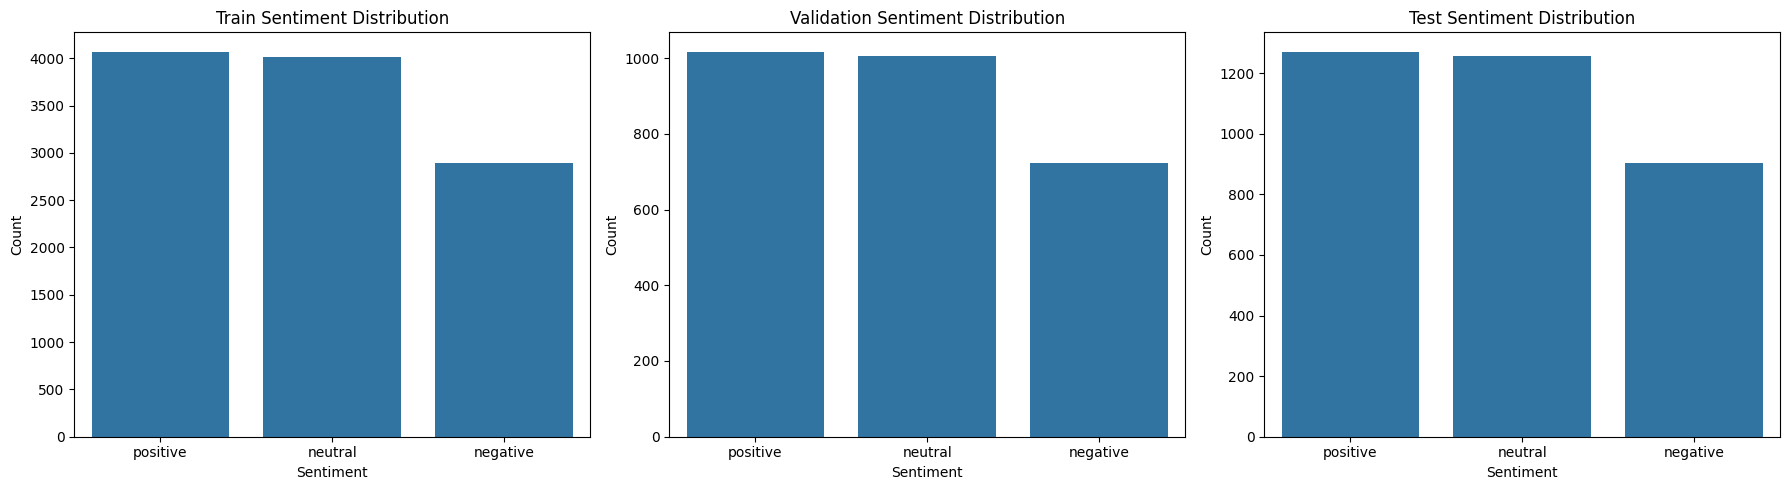

Distribusi Sentimen - Train Set:
label
positive    4070
neutral     4018
negative    2888
Name: count, dtype: int64 

Distribusi Sentimen - Validation Set:
label
positive    1017
neutral     1005
negative     722
Name: count, dtype: int64 

Distribusi Sentimen - Test Set:
label
positive    1271
neutral     1256
negative     903
Name: count, dtype: int64 



In [ ]:
col_names = ['text', 'label']

train_df = pd.read_csv(train_dataset_path, sep='\t', header=None, names=col_names)
valid_df = pd.read_csv(valid_dataset_path, sep='\t', header=None, names=col_names)
test_df = pd.read_csv(test_dataset_path, sep='\t', header=None, names=col_names)

# Assuming the sentiment column is the second column (index 1)
train_sentiment_counts = train_df['label'].value_counts()
valid_sentiment_counts = valid_df['label'].value_counts()
test_sentiment_counts = test_df['label'].value_counts()

# Create the plot
plt.figure(figsize=(18, 5))  # Disesuaikan ukurannya untuk 3 subplot

# Train
plt.subplot(1, 3, 1)
sns.barplot(x=train_sentiment_counts.index, y=train_sentiment_counts.values)
plt.title('Train Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')

# Validation
plt.subplot(1, 3, 2)
sns.barplot(x=valid_sentiment_counts.index, y=valid_sentiment_counts.values)
plt.title('Validation Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')

# Test
plt.subplot(1, 3, 3)
sns.barplot(x=test_sentiment_counts.index, y=test_sentiment_counts.values)
plt.title('Test Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

print("Distribusi Sentimen - Train Set:")
print(train_sentiment_counts, "\n")

print("Distribusi Sentimen - Validation Set:")
print(valid_sentiment_counts, "\n")

print("Distribusi Sentimen - Test Set:")
print(test_sentiment_counts, "\n")

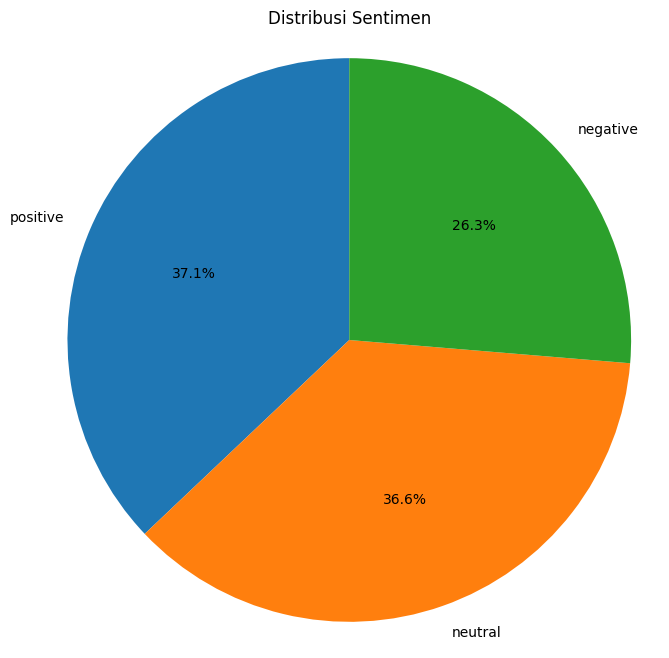

In [ ]:
total_sentiment_counts = train_sentiment_counts + valid_sentiment_counts + test_sentiment_counts

plt.figure(figsize=(8, 8))
plt.pie(total_sentiment_counts, labels=total_sentiment_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Distribusi Sentimen')
plt.axis('equal')
plt.show()


In [ ]:
###
# common functions
###
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

def count_param(module, trainable=False):
    if trainable:
        return sum(p.numel() for p in module.parameters() if p.requires_grad)
    else:
        return sum(p.numel() for p in module.parameters())

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def metrics_to_string(metric_dict):
    string_list = []
    for key, value in metric_dict.items():
        string_list.append('{}:{:.2f}'.format(key, value))
    return ' '.join(string_list)



In [ ]:
# Set random seed
set_seed(26092020)

## Model IndoRoBERTa

### Learning Rate 1e-5

In [ ]:
tokenizer1 = RobertaTokenizer.from_pretrained('flax-community/indonesian-roberta-base')
config1 = RobertaConfig.from_pretrained('flax-community/indonesian-roberta-base')
config1.num_labels = DocumentSentimentDataset.NUM_LABELS
model1 = RobertaForSequenceClassification.from_pretrained('flax-community/indonesian-roberta-base', config=config1)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/292 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/808k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/467k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.38M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/671 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at flax-community/indonesian-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
model1

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
         

In [ ]:
count_param(model1)

124647939

In [ ]:
indoroberta_param_count = count_param(model1, trainable=True)

In [ ]:
train_dataset1 = DocumentSentimentDataset(train_dataset_path, tokenizer1, lowercase=True)
valid_dataset1 = DocumentSentimentDataset(valid_dataset_path, tokenizer1, lowercase=True)
test_dataset1 = DocumentSentimentDataset(test_dataset_path, tokenizer1, lowercase=True)

train_loader1 = DocumentSentimentDataLoader(dataset=train_dataset1, max_seq_len=512, batch_size=32, num_workers=2, shuffle=True)
valid_loader1 = DocumentSentimentDataLoader(dataset=valid_dataset1, max_seq_len=512, batch_size=32, num_workers=2, shuffle=False)
test_loader1 = DocumentSentimentDataLoader(dataset=test_dataset1, max_seq_len=512, batch_size=32, num_workers=2, shuffle=False)

In [ ]:
w2i, i2w = DocumentSentimentDataset.LABEL2INDEX, DocumentSentimentDataset.INDEX2LABEL
print(w2i)
print(i2w)

{'positive': 0, 'neutral': 1, 'negative': 2}
{0: 'positive', 1: 'neutral', 2: 'negative'}


In [ ]:
text = 'bacot'
subwords = tokenizer1.encode(text)
subwords = torch.LongTensor(subwords).view(1, -1).to(model1.device)

logits = model1(subwords)[0]
label = torch.topk(logits, k=1, dim=-1)[1].squeeze().item()

print(f'Text: {text} | Label : {i2w[label]} ({F.softmax(logits, dim=-1).squeeze()[label] * 100:.3f}%)')

Text: bacot | Label : positive (43.185%)


In [ ]:
text = 'taktik pelatih sty bagus'
subwords = tokenizer1.encode(text)
subwords = torch.LongTensor(subwords).view(1, -1).to(model1.device)

logits = model1(subwords)[0]
label = torch.topk(logits, k=1, dim=-1)[1].squeeze().item()

print(f'Text: {text} | Label : {i2w[label]} ({F.softmax(logits, dim=-1).squeeze()[label] * 100:.3f}%)')

Text: taktik pelatih sty bagus | Label : positive (42.031%)


In [ ]:
optimizer = optim.Adam(model1.parameters(), lr=1e-5)
model = model1.cuda()


In [ ]:
# Metrik penyimpanan
train_losses1, train_accuracies1 = [], []
valid_losses1, valid_accuracies1 = [], []

# Early stopping
patience = 3
best_valid_loss = float('inf')
best_model_state = None
counter = 0

torch.cuda.reset_peak_memory_stats()
start_time = time.time()

n_epochs = 15

for epoch in range(n_epochs):
    print(f"\nEpoch {epoch+1}/{n_epochs}")

    # === TRAINING ===
    model.train()
    torch.set_grad_enabled(True)

    total_train_loss = 0
    list_hyp, list_label = [], []

    train_pbar = tqdm(train_loader1, desc=f"Training Epoch {epoch+1}", leave=True)
    for i, batch_data in enumerate(train_pbar):
        loss, batch_hyp, batch_label = forward_sequence_classification(model, batch_data[:-1], i2w=i2w, device='cuda')
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
        list_hyp += batch_hyp
        list_label += batch_label

    train_metrics = document_sentiment_metrics_fn(list_hyp, list_label)
    avg_train_loss = total_train_loss / len(train_loader1)
    train_losses1.append(avg_train_loss)
    train_accuracies1.append(train_metrics['ACC'])

    # === VALIDATION ===
    model.eval()
    torch.set_grad_enabled(False)

    total_valid_loss = 0
    list_hyp_valid, list_label_valid = [], []

    valid_pbar = tqdm(valid_loader1, desc=f"Validating Epoch {epoch+1}", leave=True)
    for batch_data in valid_pbar:
        loss, batch_hyp, batch_label = forward_sequence_classification(model, batch_data[:-1], i2w=i2w, device='cuda')
        total_valid_loss += loss.item()
        list_hyp_valid += batch_hyp
        list_label_valid += batch_label

    valid_metrics = document_sentiment_metrics_fn(list_hyp_valid, list_label_valid)
    avg_valid_loss = total_valid_loss / len(valid_loader1)
    valid_losses1.append(avg_valid_loss)
    valid_accuracies1.append(valid_metrics['ACC'])

    print(f"Epoch {epoch+1}/{n_epochs} | "
          f"Train Loss: {avg_train_loss:.4f} | Train Acc: {train_metrics['ACC']:.4f} | "
          f"Valid Loss: {avg_valid_loss:.4f} | Valid Acc: {valid_metrics['ACC']:.4f}")

    # === EARLY STOPPING ===
    if avg_valid_loss < best_valid_loss:
        best_valid_loss = avg_valid_loss
        best_model_state = copy.deepcopy(model.state_dict())
        counter = 0
    else:
        counter += 1
        print(f"Valid loss tidak membaik selama {counter} epoch berturut-turut.")
        if counter >= patience:
            print(f"Early stopping aktif di epoch {epoch+1}. Training dihentikan.")
            break

# Load model terbaik
if best_model_state is not None:
    model.load_state_dict(best_model_state)

end_time = time.time()
indoroberta1_train_time = end_time - start_time
indoroberta1_peak_memory = torch.cuda.max_memory_allocated() / 1024**2

print(f"\nIndoRoberta1 - Waktu training: {indoroberta1_train_time:.2f} detik | Peak memory: {indoroberta1_peak_memory:.2f} MB")



Epoch 1/15


Validating Epoch 1: 100%|██████████| 86/86 [00:05<00:00, 15.14it/s]


Epoch 1/15 | Train Loss: 0.8355 | Train Acc: 0.6024 | Valid Loss: 0.7490 | Valid Acc: 0.6866

Epoch 2/15


Validating Epoch 2: 100%|██████████| 86/86 [00:05<00:00, 15.36it/s]


Epoch 2/15 | Train Loss: 0.6578 | Train Acc: 0.7142 | Valid Loss: 0.6787 | Valid Acc: 0.7085

Epoch 3/15


Validating Epoch 3: 100%|██████████| 86/86 [00:05<00:00, 15.13it/s]


Epoch 3/15 | Train Loss: 0.5664 | Train Acc: 0.7636 | Valid Loss: 0.6741 | Valid Acc: 0.7128

Epoch 4/15


Validating Epoch 4: 100%|██████████| 86/86 [00:05<00:00, 14.90it/s]


Epoch 4/15 | Train Loss: 0.4899 | Train Acc: 0.8011 | Valid Loss: 0.7099 | Valid Acc: 0.7252
Valid loss tidak membaik selama 1 epoch berturut-turut.

Epoch 5/15


Validating Epoch 5: 100%|██████████| 86/86 [00:05<00:00, 15.25it/s]


Epoch 5/15 | Train Loss: 0.4111 | Train Acc: 0.8389 | Valid Loss: 0.7439 | Valid Acc: 0.7234
Valid loss tidak membaik selama 2 epoch berturut-turut.

Epoch 6/15


Validating Epoch 6: 100%|██████████| 86/86 [00:05<00:00, 15.37it/s]


Epoch 6/15 | Train Loss: 0.3386 | Train Acc: 0.8682 | Valid Loss: 0.7959 | Valid Acc: 0.7208
Valid loss tidak membaik selama 3 epoch berturut-turut.
Early stopping aktif di epoch 6. Training dihentikan.

IndoRoberta1 - Waktu training: 452.40 detik | Peak memory: 4230.98 MB


In [ ]:
!nvidia-smi

Sun May 18 12:55:20 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   74C    P0             33W /   70W |    5430MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

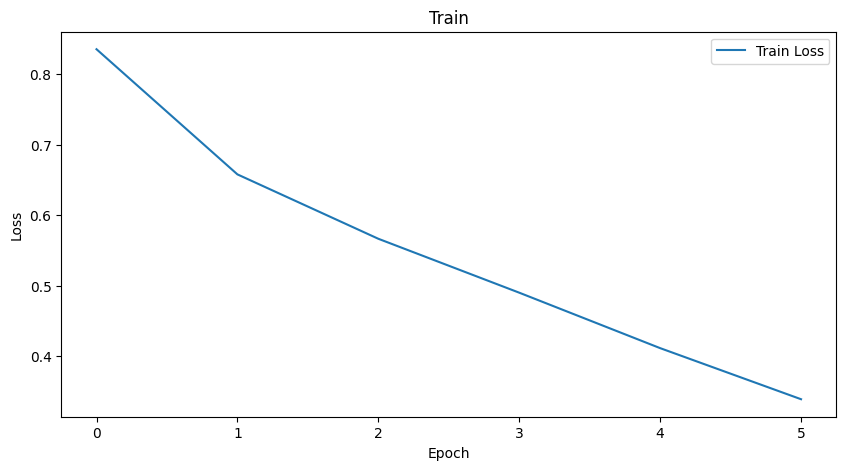

In [ ]:
# Plot loss
plt.figure(figsize=(10,5))
plt.plot(train_losses1, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Train')
plt.show()

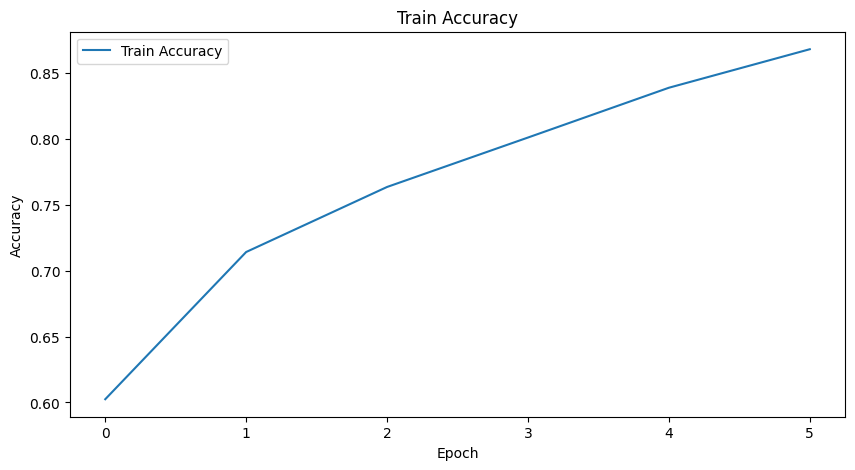

In [ ]:
# Plot akurasi
plt.figure(figsize=(10,5))
plt.plot(train_accuracies1, label='Train Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Train Accuracy')
plt.show()

In [ ]:
import os

output_dir = '/content/drive/MyDrive/Skripsi/Piala_Asia/20rb/result/IndoRoBERTa_Results/1'
os.makedirs(output_dir, exist_ok=True)

In [ ]:
# Simpan hasil prediksi ke CSV
all_texts = []

# Ulangi evaluasi untuk menyimpan teks, label, dan prediksi
model.eval()
torch.set_grad_enabled(False)

list_hyp, list_label = [], []
all_texts = []

test_pbar = tqdm(test_loader1, leave=True, total=len(test_loader1))  # atau test_loader2 untuk BERT
for i, batch_data in enumerate(test_pbar):
    loss, batch_hyp, batch_label = forward_sequence_classification(model, batch_data[:-1], i2w=i2w, device='cuda')

    list_hyp += batch_hyp
    list_label += batch_label
    batch_texts = batch_data[-1]  # bagian terakhir adalah teks asli
    all_texts += batch_texts

# Simpan ke dalam DataFrame dan CSV
df_result = pd.DataFrame({
    'text': all_texts,
    'true_label': list_label,
    'predicted_label': list_hyp
})

df_result.to_csv(os.path.join(output_dir,'hasil_prediksi_model1.csv'), index=False)  # Ganti ke model2 jika ingin simpan untuk BERT
test_metrics = document_sentiment_metrics_fn(list_hyp, list_label)
print(f'\nTest Metrics: {metrics_to_string(test_metrics)}')

100%|██████████| 108/108 [00:08<00:00, 13.31it/s]


Test Metrics: ACC:0.72 F1:0.71 REC:0.72 PRE:0.71


In [ ]:
# === SIMPAN METRIK PER EPOCH ===
df_metrics_epoch = pd.DataFrame({
    'epoch': list(range(1, len(train_losses1)+1)),
    'train_loss': train_losses1,
    'train_accuracy': train_accuracies1,
    'valid_loss': valid_losses1,
    'valid_accuracy': valid_accuracies1
})
df_metrics_epoch.to_csv(os.path.join(output_dir,'indoroberta1_metrics_per_epoch.csv'), index=False)

# === SIMPAN WAKTU DAN MEMORI ===
df_time_memory = pd.DataFrame({
    'model': ['IndoRoBERTa'],
    'train_time_seconds': [indoroberta1_train_time],
    'peak_memory_MB': [indoroberta1_peak_memory]
})
df_time_memory.to_csv(os.path.join(output_dir,'indoroberta1_time_memory.csv'), index=False)

# === SIMPAN METRIK TEST ===
test_metrics = document_sentiment_metrics_fn(list_hyp, list_label)
test_metrics_dict = {
    'model': 'IndoRoBERTa',
    **test_metrics
}
df_test_metrics = pd.DataFrame([test_metrics_dict])
df_test_metrics.to_csv(os.path.join(output_dir,'indoroberta1_test_metrics.csv'), index=False)

# === SIMPAN CLASSIFICATION REPORT ===
report_dict = classification_report(list_label, list_hyp, output_dict=True, zero_division=0)
df_report = pd.DataFrame(report_dict).transpose()
df_report.to_csv(os.path.join(output_dir,'indoroberta1_classification_report.csv'))

In [ ]:
# classification report
print(classification_report(list_label, list_hyp))

              precision    recall  f1-score   support

    negative       0.62      0.71      0.66       903
     neutral       0.67      0.62      0.64      1256
    positive       0.84      0.81      0.83      1271

    accuracy                           0.72      3430
   macro avg       0.71      0.72      0.71      3430
weighted avg       0.72      0.72      0.72      3430



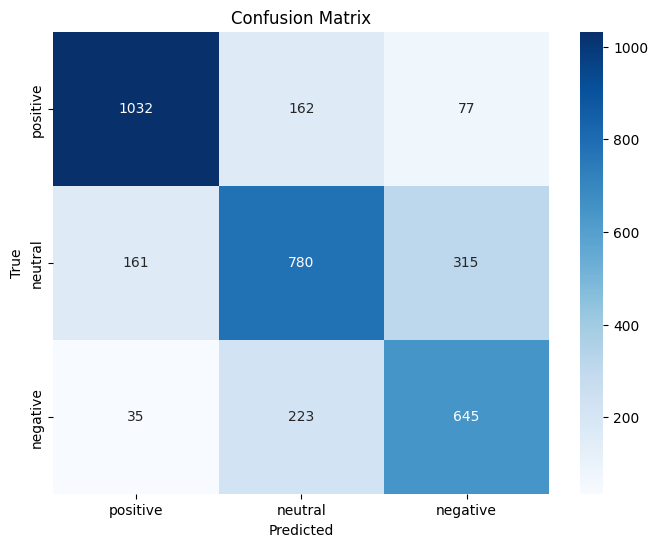

In [ ]:
# === SIMPAN CONFUSION MATRIX ===
labels = list(w2i.keys())
cm = confusion_matrix(list_label, list_hyp, labels=labels)
df_conf_matrix = pd.DataFrame(cm, index=[f"True_{l}" for l in labels], columns=[f"Pred_{l}" for l in labels])
df_conf_matrix.to_csv(os.path.join(output_dir,'indoroberta1_confusion_matrix.csv'))

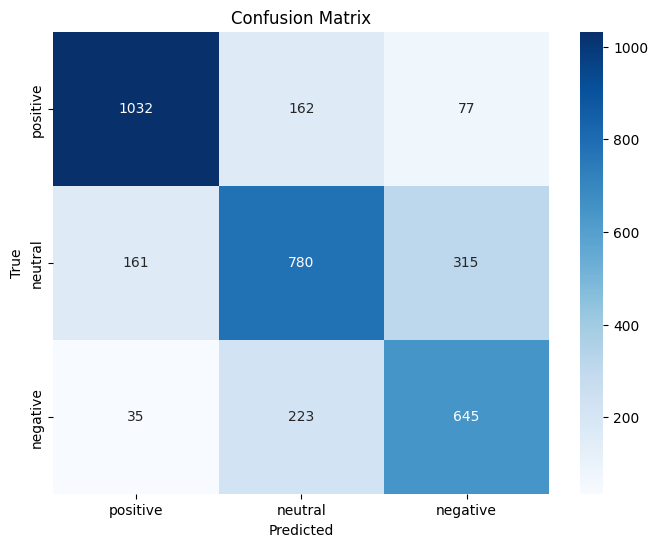

In [ ]:
# === TAMPILKAN CONFUSION MATRIX ===
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.savefig(os.path.join(output_dir, 'confusion_matrix.png'))
plt.show()

In [ ]:
text = 'rafael mainnya jelek sekali'
subwords = tokenizer1.encode(text)
subwords = torch.LongTensor(subwords).view(1, -1).to(model1.device)

logits = model1(subwords)[0]
label = torch.topk(logits, k=1, dim=-1)[1].squeeze().item()

print(f'Text: {text} | Label : {i2w[label]} ({F.softmax(logits, dim=-1).squeeze()[label] * 100:.3f}%)')

Text: rafael mainnya jelek sekali | Label : negative (94.026%)


In [ ]:
text = 'sty stay'
subwords = tokenizer1.encode(text)
subwords = torch.LongTensor(subwords).view(1, -1).to(model1.device)

logits = model1(subwords)[0]
label = torch.topk(logits, k=1, dim=-1)[1].squeeze().item()

print(f'Text: {text} | Label : {i2w[label]} ({F.softmax(logits, dim=-1).squeeze()[label] * 100:.3f}%)')

Text: sty stay | Label : positive (99.117%)


### Learning Rate 3e-6

In [ ]:
tokenizer2 = RobertaTokenizer.from_pretrained('flax-community/indonesian-roberta-base')
config2 = RobertaConfig.from_pretrained('flax-community/indonesian-roberta-base')
config2.num_labels = DocumentSentimentDataset.NUM_LABELS
model2 = RobertaForSequenceClassification.from_pretrained('flax-community/indonesian-roberta-base', config=config2)


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at flax-community/indonesian-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
model2

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
         

In [ ]:
train_dataset2 = DocumentSentimentDataset(train_dataset_path, tokenizer2, lowercase=True)
valid_dataset2 = DocumentSentimentDataset(valid_dataset_path, tokenizer2, lowercase=True)
test_dataset2 = DocumentSentimentDataset(test_dataset_path, tokenizer2, lowercase=True)

train_loader2 = DocumentSentimentDataLoader(dataset=train_dataset2, max_seq_len=512, batch_size=32, num_workers=2, shuffle=True)
valid_loader2 = DocumentSentimentDataLoader(dataset=valid_dataset2, max_seq_len=512, batch_size=32, num_workers=2, shuffle=False)
test_loader2 = DocumentSentimentDataLoader(dataset=test_dataset2, max_seq_len=512, batch_size=32, num_workers=2, shuffle=False)

In [ ]:
w2i, i2w = DocumentSentimentDataset.LABEL2INDEX, DocumentSentimentDataset.INDEX2LABEL
print(w2i)
print(i2w)

{'positive': 0, 'neutral': 1, 'negative': 2}
{0: 'positive', 1: 'neutral', 2: 'negative'}


In [ ]:
text = 'bacot'
subwords = tokenizer2.encode(text)
subwords = torch.LongTensor(subwords).view(1, -1).to(model2.device)

logits = model2(subwords)[0]
label = torch.topk(logits, k=1, dim=-1)[1].squeeze().item()

print(f'Text: {text} | Label : {i2w[label]} ({F.softmax(logits, dim=-1).squeeze()[label] * 100:.3f}%)')

Text: bacot | Label : neutral (40.748%)


In [ ]:
text = 'taktik pelatih sty bagus'
subwords = tokenizer2.encode(text)
subwords = torch.LongTensor(subwords).view(1, -1).to(model2.device)

logits = model2(subwords)[0]
label = torch.topk(logits, k=1, dim=-1)[1].squeeze().item()

print(f'Text: {text} | Label : {i2w[label]} ({F.softmax(logits, dim=-1).squeeze()[label] * 100:.3f}%)')

Text: taktik pelatih sty bagus | Label : neutral (35.650%)


In [ ]:
optimizer = optim.Adam(model2.parameters(), lr=3e-6)
model = model2.cuda()


In [ ]:
# Metrik penyimpanan
train_losses2, train_accuracies2 = [], []
valid_losses2, valid_accuracies2 = [], []

# Early stopping
patience = 3
best_valid_loss = float('inf')
best_model_state = None
counter = 0

torch.cuda.reset_peak_memory_stats()
start_time = time.time()

n_epochs = 15

for epoch in range(n_epochs):
    print(f"\nEpoch {epoch+1}/{n_epochs}")

    # === TRAINING ===
    model.train()
    torch.set_grad_enabled(True)

    total_train_loss = 0
    list_hyp, list_label = [], []

    train_pbar = tqdm(train_loader2, desc=f"Training Epoch {epoch+1}", leave=True)
    for i, batch_data in enumerate(train_pbar):
        loss, batch_hyp, batch_label = forward_sequence_classification(model, batch_data[:-1], i2w=i2w, device='cuda')
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
        list_hyp += batch_hyp
        list_label += batch_label

    train_metrics = document_sentiment_metrics_fn(list_hyp, list_label)
    avg_train_loss = total_train_loss / len(train_loader2)
    train_losses2.append(avg_train_loss)
    train_accuracies2.append(train_metrics['ACC'])

    # === VALIDATION ===
    model.eval()
    torch.set_grad_enabled(False)

    total_valid_loss = 0
    list_hyp_valid, list_label_valid = [], []

    valid_pbar = tqdm(valid_loader2, desc=f"Validating Epoch {epoch+1}", leave=True)
    for batch_data in valid_pbar:
        loss, batch_hyp, batch_label = forward_sequence_classification(model, batch_data[:-1], i2w=i2w, device='cuda')
        total_valid_loss += loss.item()
        list_hyp_valid += batch_hyp
        list_label_valid += batch_label

    valid_metrics = document_sentiment_metrics_fn(list_hyp_valid, list_label_valid)
    avg_valid_loss = total_valid_loss / len(valid_loader2)
    valid_losses2.append(avg_valid_loss)
    valid_accuracies2.append(valid_metrics['ACC'])

    print(f"Epoch {epoch+1}/{n_epochs} | "
          f"Train Loss: {avg_train_loss:.4f} | Train Acc: {train_metrics['ACC']:.4f} | "
          f"Valid Loss: {avg_valid_loss:.4f} | Valid Acc: {valid_metrics['ACC']:.4f}")

    # === EARLY STOPPING ===
    if avg_valid_loss < best_valid_loss:
        best_valid_loss = avg_valid_loss
        best_model_state = copy.deepcopy(model.state_dict())
        counter = 0
    else:
        counter += 1
        print(f"Valid loss tidak membaik selama {counter} epoch berturut-turut.")
        if counter >= patience:
            print(f"Early stopping aktif di epoch {epoch+1}. Training dihentikan.")
            break

# Load model terbaik
if best_model_state is not None:
    model.load_state_dict(best_model_state)

end_time = time.time()
indoroberta2_train_time = end_time - start_time
indoroberta2_peak_memory = torch.cuda.max_memory_allocated() / 1024**2

print(f"\nIndoRoberta2 - Waktu training: {indoroberta2_train_time:.2f} detik | Peak memory: {indoroberta2_peak_memory:.2f} MB")



Epoch 1/15


Validating Epoch 1: 100%|██████████| 86/86 [00:05<00:00, 15.13it/s]


Epoch 1/15 | Train Loss: 0.9739 | Train Acc: 0.5080 | Valid Loss: 0.8087 | Valid Acc: 0.6239

Epoch 2/15


Validating Epoch 2: 100%|██████████| 86/86 [00:05<00:00, 15.03it/s]


Epoch 2/15 | Train Loss: 0.7776 | Train Acc: 0.6398 | Valid Loss: 0.7277 | Valid Acc: 0.6735

Epoch 3/15


Validating Epoch 3: 100%|██████████| 86/86 [00:05<00:00, 15.35it/s]


Epoch 3/15 | Train Loss: 0.7032 | Train Acc: 0.6826 | Valid Loss: 0.6950 | Valid Acc: 0.6979

Epoch 4/15


Validating Epoch 4: 100%|██████████| 86/86 [00:05<00:00, 15.31it/s]


Epoch 4/15 | Train Loss: 0.6549 | Train Acc: 0.7163 | Valid Loss: 0.7046 | Valid Acc: 0.6972
Valid loss tidak membaik selama 1 epoch berturut-turut.

Epoch 5/15


Validating Epoch 5: 100%|██████████| 86/86 [00:05<00:00, 14.96it/s]


Epoch 5/15 | Train Loss: 0.6144 | Train Acc: 0.7358 | Valid Loss: 0.6835 | Valid Acc: 0.7048

Epoch 6/15


Validating Epoch 6: 100%|██████████| 86/86 [00:05<00:00, 15.06it/s]


Epoch 6/15 | Train Loss: 0.5827 | Train Acc: 0.7496 | Valid Loss: 0.6899 | Valid Acc: 0.7055
Valid loss tidak membaik selama 1 epoch berturut-turut.

Epoch 7/15


Validating Epoch 7: 100%|██████████| 86/86 [00:05<00:00, 15.34it/s]


Epoch 7/15 | Train Loss: 0.5543 | Train Acc: 0.7674 | Valid Loss: 0.6998 | Valid Acc: 0.7132
Valid loss tidak membaik selama 2 epoch berturut-turut.

Epoch 8/15


Validating Epoch 8: 100%|██████████| 86/86 [00:05<00:00, 15.32it/s]


Epoch 8/15 | Train Loss: 0.5222 | Train Acc: 0.7865 | Valid Loss: 0.7035 | Valid Acc: 0.7099
Valid loss tidak membaik selama 3 epoch berturut-turut.
Early stopping aktif di epoch 8. Training dihentikan.

IndoRoberta2 - Waktu training: 608.14 detik | Peak memory: 5206.34 MB


In [ ]:
!nvidia-smi

Sun May 18 13:18:16 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   70C    P0             32W /   70W |    5846MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

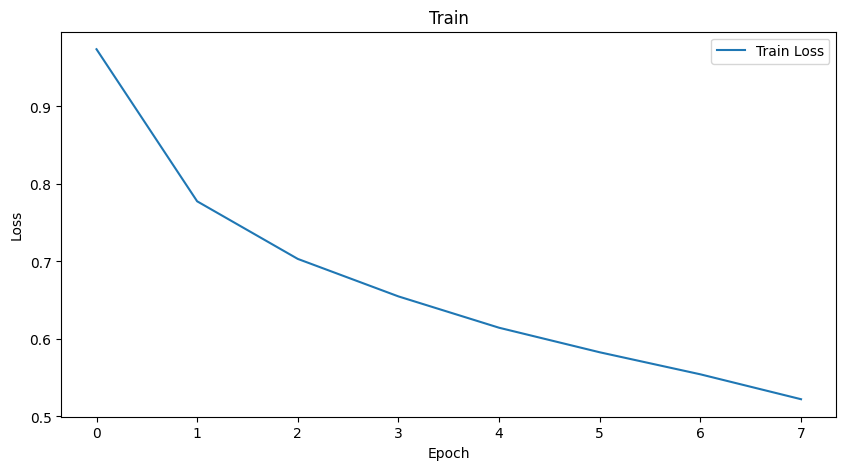

In [ ]:
# Plot loss
plt.figure(figsize=(10,5))
plt.plot(train_losses2, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Train')
plt.show()

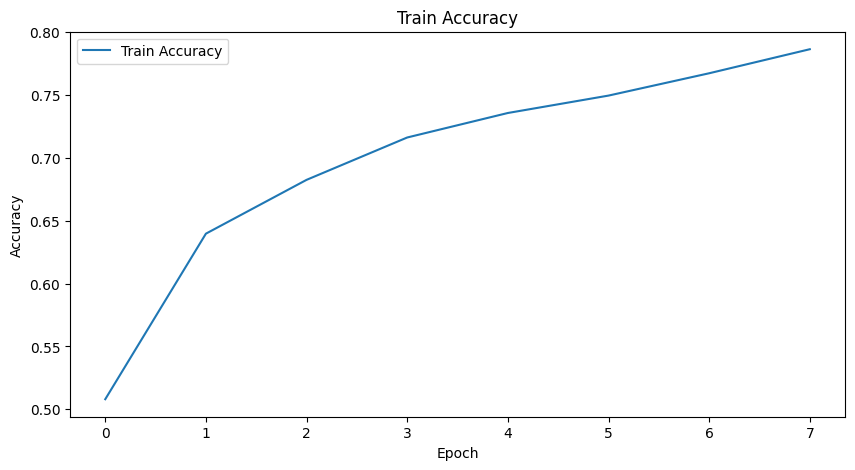

In [ ]:
# Plot akurasi
plt.figure(figsize=(10,5))
plt.plot(train_accuracies2, label='Train Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Train Accuracy')
plt.show()

In [ ]:
output_dir = '/content/drive/MyDrive/Skripsi/Piala_Asia/20rb/result/IndoRoBERTa_Results/2'
os.makedirs(output_dir, exist_ok=True)

In [ ]:
# Simpan hasil prediksi ke CSV
all_texts = []

# Ulangi evaluasi untuk menyimpan teks, label, dan prediksi
model.eval()
torch.set_grad_enabled(False)

list_hyp, list_label = [], []
all_texts = []

test_pbar = tqdm(test_loader2, leave=True, total=len(test_loader2))  # atau test_loader2 untuk BERT
for i, batch_data in enumerate(test_pbar):
    loss, batch_hyp, batch_label = forward_sequence_classification(model, batch_data[:-1], i2w=i2w, device='cuda')

    list_hyp += batch_hyp
    list_label += batch_label
    batch_texts = batch_data[-1]  # bagian terakhir adalah teks asli
    all_texts += batch_texts

# Simpan ke dalam DataFrame dan CSV
df_result = pd.DataFrame({
    'text': all_texts,
    'true_label': list_label,
    'predicted_label': list_hyp
})

df_result.to_csv(os.path.join(output_dir,'hasil_prediksi_model2.csv'), index=False)  # Ganti ke model2 jika ingin simpan untuk BERT
test_metrics = document_sentiment_metrics_fn(list_hyp, list_label)
print(f'\nTest Metrics: {metrics_to_string(test_metrics)}')

100%|██████████| 108/108 [00:07<00:00, 15.28it/s]


Test Metrics: ACC:0.72 F1:0.71 REC:0.71 PRE:0.72


In [ ]:
# === SIMPAN METRIK PER EPOCH ===
df_metrics_epoch = pd.DataFrame({
    'epoch': list(range(1, len(train_losses2)+1)),
    'train_loss': train_losses2,
    'train_accuracy': train_accuracies2,
    'valid_loss': valid_losses2,
    'valid_accuracy': valid_accuracies2
})
df_metrics_epoch.to_csv(os.path.join(output_dir,'indoroberta_metrics_per_epoch.csv'), index=False)

# === SIMPAN WAKTU DAN MEMORI ===
df_time_memory = pd.DataFrame({
    'model': ['IndoRoBERTa'],
    'train_time_seconds': [indoroberta2_train_time],
    'peak_memory_MB': [indoroberta2_peak_memory]
})
df_time_memory.to_csv(os.path.join(output_dir,'indoroberta_time_memory.csv'), index=False)

# === SIMPAN METRIK TEST ===
test_metrics = document_sentiment_metrics_fn(list_hyp, list_label)
test_metrics_dict = {
    'model': 'IndoRoBERTa',
    **test_metrics
}
df_test_metrics = pd.DataFrame([test_metrics_dict])
df_test_metrics.to_csv(os.path.join(output_dir,'indoroberta_test_metrics.csv'), index=False)

# === SIMPAN CLASSIFICATION REPORT ===
report_dict = classification_report(list_label, list_hyp, output_dict=True, zero_division=0)
df_report = pd.DataFrame(report_dict).transpose()
df_report.to_csv(os.path.join(output_dir,'indoroberta_classification_report.csv'))

In [ ]:
# classification report
print(classification_report(list_label, list_hyp))

              precision    recall  f1-score   support

    negative       0.67      0.62      0.64       903
     neutral       0.65      0.70      0.67      1256
    positive       0.83      0.81      0.82      1271

    accuracy                           0.72      3430
   macro avg       0.72      0.71      0.71      3430
weighted avg       0.72      0.72      0.72      3430



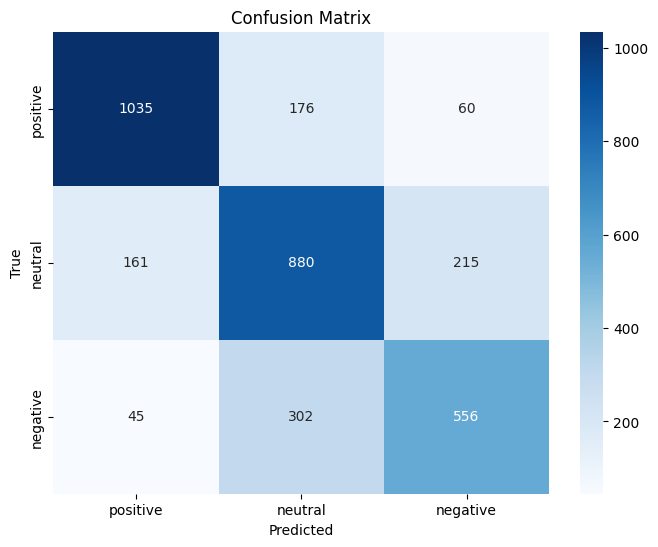

In [ ]:
# === SIMPAN CONFUSION MATRIX ===
labels = list(w2i.keys())
cm = confusion_matrix(list_label, list_hyp, labels=labels)
df_conf_matrix = pd.DataFrame(cm, index=[f"True_{l}" for l in labels], columns=[f"Pred_{l}" for l in labels])
df_conf_matrix.to_csv(os.path.join(output_dir,'indoroberta_confusion_matrix.csv'))

# === TAMPILKAN CONFUSION MATRIX ===
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.savefig(os.path.join(output_dir, 'confusion_matrix.png'))
plt.show()

In [ ]:
text = 'rafael mainnya jelek sekali'
subwords = tokenizer2.encode(text)
subwords = torch.LongTensor(subwords).view(1, -1).to(model2.device)

logits = model2(subwords)[0]
label = torch.topk(logits, k=1, dim=-1)[1].squeeze().item()

print(f'Text: {text} | Label : {i2w[label]} ({F.softmax(logits, dim=-1).squeeze()[label] * 100:.3f}%)')

Text: rafael mainnya jelek sekali | Label : negative (87.995%)


In [ ]:
text = 'sty stay'
subwords = tokenizer2.encode(text)
subwords = torch.LongTensor(subwords).view(1, -1).to(model2.device)

logits = model2(subwords)[0]
label = torch.topk(logits, k=1, dim=-1)[1].squeeze().item()

print(f'Text: {text} | Label : {i2w[label]} ({F.softmax(logits, dim=-1).squeeze()[label] * 100:.3f}%)')

Text: sty stay | Label : positive (99.083%)


### Learning Rate 5e-5

In [ ]:
tokenizer3 = RobertaTokenizer.from_pretrained('flax-community/indonesian-roberta-base')
config3 = RobertaConfig.from_pretrained('flax-community/indonesian-roberta-base')
config3.num_labels = DocumentSentimentDataset.NUM_LABELS
model3 = RobertaForSequenceClassification.from_pretrained('flax-community/indonesian-roberta-base', config=config3)


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at flax-community/indonesian-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
model3

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
         

In [ ]:
train_dataset3 = DocumentSentimentDataset(train_dataset_path, tokenizer3, lowercase=True)
valid_dataset3 = DocumentSentimentDataset(valid_dataset_path, tokenizer3, lowercase=True)
test_dataset3 = DocumentSentimentDataset(test_dataset_path, tokenizer3, lowercase=True)

train_loader3 = DocumentSentimentDataLoader(dataset=train_dataset3, max_seq_len=512, batch_size=32, num_workers=2, shuffle=True)
valid_loader3 = DocumentSentimentDataLoader(dataset=valid_dataset3, max_seq_len=512, batch_size=32, num_workers=2, shuffle=False)
test_loader3 = DocumentSentimentDataLoader(dataset=test_dataset3, max_seq_len=512, batch_size=32, num_workers=2, shuffle=False)

In [ ]:
w2i, i2w = DocumentSentimentDataset.LABEL2INDEX, DocumentSentimentDataset.INDEX2LABEL
print(w2i)
print(i2w)

{'positive': 0, 'neutral': 1, 'negative': 2}
{0: 'positive', 1: 'neutral', 2: 'negative'}


In [ ]:
text = 'bacot'
subwords = tokenizer3.encode(text)
subwords = torch.LongTensor(subwords).view(1, -1).to(model3.device)

logits = model3(subwords)[0]
label = torch.topk(logits, k=1, dim=-1)[1].squeeze().item()

print(f'Text: {text} | Label : {i2w[label]} ({F.softmax(logits, dim=-1).squeeze()[label] * 100:.3f}%)')

Text: bacot | Label : negative (37.417%)


In [ ]:
text = 'taktik pelatih sty bagus'
subwords = tokenizer3.encode(text)
subwords = torch.LongTensor(subwords).view(1, -1).to(model3.device)

logits = model3(subwords)[0]
label = torch.topk(logits, k=1, dim=-1)[1].squeeze().item()

print(f'Text: {text} | Label : {i2w[label]} ({F.softmax(logits, dim=-1).squeeze()[label] * 100:.3f}%)')

Text: taktik pelatih sty bagus | Label : negative (41.782%)


In [ ]:
optimizer = optim.Adam(model3.parameters(), lr=5e-5)
model = model3.cuda()


In [ ]:
# Metrik penyimpanan
train_losses3, train_accuracies3 = [], []
valid_losses3, valid_accuracies3 = [], []

# Early stopping
patience = 3
best_valid_loss = float('inf')
best_model_state = None
counter = 0

torch.cuda.reset_peak_memory_stats()
start_time = time.time()

n_epochs = 15

for epoch in range(n_epochs):
    print(f"\nEpoch {epoch+1}/{n_epochs}")

    # === TRAINING ===
    model.train()
    torch.set_grad_enabled(True)

    total_train_loss = 0
    list_hyp, list_label = [], []

    train_pbar = tqdm(train_loader3, desc=f"Training Epoch {epoch+1}", leave=True)
    for i, batch_data in enumerate(train_pbar):
        loss, batch_hyp, batch_label = forward_sequence_classification(model, batch_data[:-1], i2w=i2w, device='cuda')
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
        list_hyp += batch_hyp
        list_label += batch_label

    train_metrics = document_sentiment_metrics_fn(list_hyp, list_label)
    avg_train_loss = total_train_loss / len(train_loader3)
    train_losses3.append(avg_train_loss)
    train_accuracies3.append(train_metrics['ACC'])

    # === VALIDATION ===
    model.eval()
    torch.set_grad_enabled(False)

    total_valid_loss = 0
    list_hyp_valid, list_label_valid = [], []

    valid_pbar = tqdm(valid_loader3, desc=f"Validating Epoch {epoch+1}", leave=True)
    for batch_data in valid_pbar:
        loss, batch_hyp, batch_label = forward_sequence_classification(model, batch_data[:-1], i2w=i2w, device='cuda')
        total_valid_loss += loss.item()
        list_hyp_valid += batch_hyp
        list_label_valid += batch_label

    valid_metrics = document_sentiment_metrics_fn(list_hyp_valid, list_label_valid)
    avg_valid_loss = total_valid_loss / len(valid_loader3)
    valid_losses3.append(avg_valid_loss)
    valid_accuracies3.append(valid_metrics['ACC'])

    print(f"Epoch {epoch+1}/{n_epochs} | "
          f"Train Loss: {avg_train_loss:.4f} | Train Acc: {train_metrics['ACC']:.4f} | "
          f"Valid Loss: {avg_valid_loss:.4f} | Valid Acc: {valid_metrics['ACC']:.4f}")

    # === EARLY STOPPING ===
    if avg_valid_loss < best_valid_loss:
        best_valid_loss = avg_valid_loss
        best_model_state = copy.deepcopy(model.state_dict())
        counter = 0
    else:
        counter += 1
        print(f"Valid loss tidak membaik selama {counter} epoch berturut-turut.")
        if counter >= patience:
            print(f"Early stopping aktif di epoch {epoch+1}. Training dihentikan.")
            break

# Load model terbaik
if best_model_state is not None:
    model.load_state_dict(best_model_state)

end_time = time.time()
indoroberta3_train_time = end_time - start_time
indoroberta3_peak_memory = torch.cuda.max_memory_allocated() / 1024**2

print(f"\nIndoRoberta3 - Waktu training: {indoroberta3_train_time:.2f} detik | Peak memory: {indoroberta3_peak_memory:.2f} MB")



Epoch 1/15


Validating Epoch 1: 100%|██████████| 86/86 [00:06<00:00, 14.07it/s]


Epoch 1/15 | Train Loss: 0.7828 | Train Acc: 0.6355 | Valid Loss: 0.6905 | Valid Acc: 0.7077

Epoch 2/15


Validating Epoch 2: 100%|██████████| 86/86 [00:05<00:00, 14.42it/s]


Epoch 2/15 | Train Loss: 0.5872 | Train Acc: 0.7542 | Valid Loss: 0.6797 | Valid Acc: 0.7289

Epoch 3/15


Validating Epoch 3: 100%|██████████| 86/86 [00:05<00:00, 15.40it/s]


Epoch 3/15 | Train Loss: 0.4437 | Train Acc: 0.8248 | Valid Loss: 0.8006 | Valid Acc: 0.7161
Valid loss tidak membaik selama 1 epoch berturut-turut.

Epoch 4/15


Validating Epoch 4: 100%|██████████| 86/86 [00:05<00:00, 14.72it/s]


Epoch 4/15 | Train Loss: 0.3217 | Train Acc: 0.8767 | Valid Loss: 0.7951 | Valid Acc: 0.7095
Valid loss tidak membaik selama 2 epoch berturut-turut.

Epoch 5/15


Validating Epoch 5: 100%|██████████| 86/86 [00:05<00:00, 15.05it/s]


Epoch 5/15 | Train Loss: 0.2449 | Train Acc: 0.9099 | Valid Loss: 1.0012 | Valid Acc: 0.7015
Valid loss tidak membaik selama 3 epoch berturut-turut.
Early stopping aktif di epoch 5. Training dihentikan.

IndoRoberta3 - Waktu training: 386.00 detik | Peak memory: 6178.54 MB


In [ ]:
!nvidia-smi

Sun May 18 13:27:17 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   72C    P0             33W /   70W |    6744MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

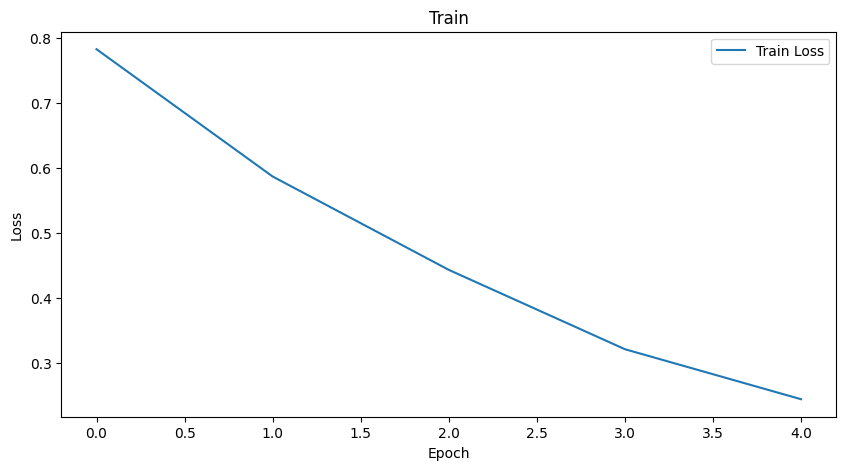

In [ ]:
# Plot loss
plt.figure(figsize=(10,5))
plt.plot(train_losses3, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Train')
plt.show()

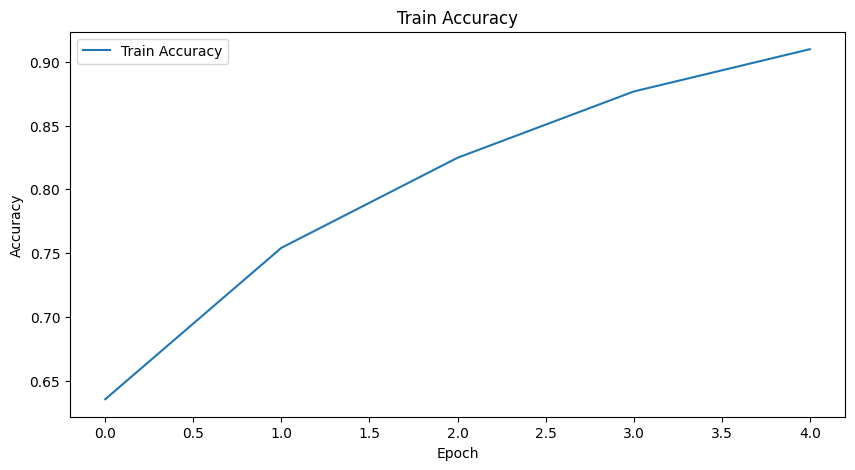

In [ ]:
# Plot akurasi
plt.figure(figsize=(10,5))
plt.plot(train_accuracies3, label='Train Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Train Accuracy')
plt.show()

In [ ]:
output_dir = '/content/drive/MyDrive/Skripsi/Piala_Asia/20rb/result/IndoRoBERTa_Results/3'
os.makedirs(output_dir, exist_ok=True)

In [ ]:
# Simpan hasil prediksi ke CSV
all_texts = []

# Ulangi evaluasi untuk menyimpan teks, label, dan prediksi
model.eval()
torch.set_grad_enabled(False)

list_hyp, list_label = [], []
all_texts = []

test_pbar = tqdm(test_loader3, leave=True, total=len(test_loader3))  # atau test_loader2 untuk BERT
for i, batch_data in enumerate(test_pbar):
    loss, batch_hyp, batch_label = forward_sequence_classification(model, batch_data[:-1], i2w=i2w, device='cuda')

    list_hyp += batch_hyp
    list_label += batch_label
    batch_texts = batch_data[-1]  # bagian terakhir adalah teks asli
    all_texts += batch_texts

# Simpan ke dalam DataFrame dan CSV
df_result = pd.DataFrame({
    'text': all_texts,
    'true_label': list_label,
    'predicted_label': list_hyp
})

df_result.to_csv(os.path.join(output_dir,'hasil_prediksi_model3.csv'), index=False)  # Ganti ke model2 jika ingin simpan untuk BERT
test_metrics = document_sentiment_metrics_fn(list_hyp, list_label)
print(f'\nTest Metrics: {metrics_to_string(test_metrics)}')

100%|██████████| 108/108 [00:07<00:00, 15.04it/s]



Test Metrics: ACC:0.72 F1:0.72 REC:0.72 PRE:0.72


In [ ]:
# === SIMPAN METRIK PER EPOCH ===
df_metrics_epoch = pd.DataFrame({
    'epoch': list(range(1, len(train_losses3)+1)),
    'train_loss': train_losses3,
    'train_accuracy': train_accuracies3,
    'valid_loss': valid_losses3,
    'valid_accuracy': valid_accuracies3
})
df_metrics_epoch.to_csv(os.path.join(output_dir,'indoroberta_metrics_per_epoch.csv'), index=False)

# === SIMPAN WAKTU DAN MEMORI ===
df_time_memory = pd.DataFrame({
    'model': ['IndoRoBERTa'],
    'train_time_seconds': [indoroberta3_train_time],
    'peak_memory_MB': [indoroberta3_peak_memory]
})
df_time_memory.to_csv(os.path.join(output_dir,'indoroberta_time_memory.csv'), index=False)

# === SIMPAN METRIK TEST ===
test_metrics = document_sentiment_metrics_fn(list_hyp, list_label)
test_metrics_dict = {
    'model': 'IndoRoBERTa',
    **test_metrics
}
df_test_metrics = pd.DataFrame([test_metrics_dict])
df_test_metrics.to_csv(os.path.join(output_dir,'indoroberta_test_metrics.csv'), index=False)

# === SIMPAN CLASSIFICATION REPORT ===
report_dict = classification_report(list_label, list_hyp, output_dict=True, zero_division=0)
df_report = pd.DataFrame(report_dict).transpose()
df_report.to_csv(os.path.join(output_dir,'indoroberta_classification_report.csv'))

In [ ]:
# classification report
print(classification_report(list_label, list_hyp))

              precision    recall  f1-score   support

    negative       0.67      0.67      0.67       903
     neutral       0.67      0.65      0.66      1256
    positive       0.82      0.83      0.82      1271

    accuracy                           0.72      3430
   macro avg       0.72      0.72      0.72      3430
weighted avg       0.72      0.72      0.72      3430



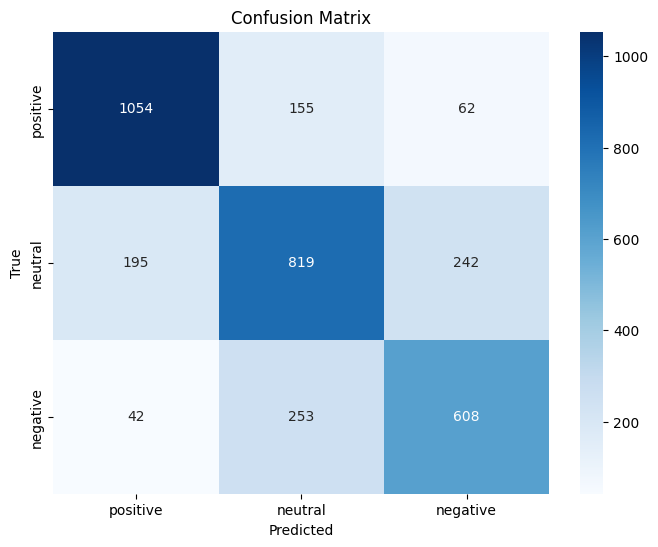

In [ ]:
# === SIMPAN CONFUSION MATRIX ===
labels = list(w2i.keys())
cm = confusion_matrix(list_label, list_hyp, labels=labels)
df_conf_matrix = pd.DataFrame(cm, index=[f"True_{l}" for l in labels], columns=[f"Pred_{l}" for l in labels])
df_conf_matrix.to_csv(os.path.join(output_dir,'indoroberta_confusion_matrix.csv'))

# === TAMPILKAN CONFUSION MATRIX ===
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.savefig(os.path.join(output_dir, 'confusion_matrix.png'))
plt.show()

In [ ]:
text = 'rafael mainnya jelek sekali'
subwords = tokenizer3.encode(text)
subwords = torch.LongTensor(subwords).view(1, -1).to(model3.device)

logits = model3(subwords)[0]
label = torch.topk(logits, k=1, dim=-1)[1].squeeze().item()

print(f'Text: {text} | Label : {i2w[label]} ({F.softmax(logits, dim=-1).squeeze()[label] * 100:.3f}%)')

Text: rafael mainnya jelek sekali | Label : negative (90.831%)


In [ ]:
text = 'sty stay'
subwords = tokenizer3.encode(text)
subwords = torch.LongTensor(subwords).view(1, -1).to(model3.device)

logits = model3(subwords)[0]
label = torch.topk(logits, k=1, dim=-1)[1].squeeze().item()

print(f'Text: {text} | Label : {i2w[label]} ({F.softmax(logits, dim=-1).squeeze()[label] * 100:.3f}%)')

Text: sty stay | Label : positive (98.877%)


## Model IndoBERT

### Learning Rate 1e-5

In [ ]:
tokenizer4 = BertTokenizer.from_pretrained('indobenchmark/indobert-large-p1')
config4 = BertConfig.from_pretrained('indobenchmark/indobert-large-p1')
config4.num_labels = DocumentSentimentDataset.NUM_LABELS
model4 = BertForSequenceClassification.from_pretrained('indobenchmark/indobert-large-p1', config=config4)


tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/229k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-large-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
model4

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 1024, padding_idx=0)
      (position_embeddings): Embedding(512, 1024)
      (token_type_embeddings): Embedding(2, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-23): 24 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (LayerNorm): LayerNorm((1

In [ ]:
count_param(model4)

335144963

In [ ]:
indobertLarge_param_count = count_param(model4, trainable=True)

In [ ]:
train_dataset4 = DocumentSentimentDataset(train_dataset_path, tokenizer4, lowercase=True)
valid_dataset4 = DocumentSentimentDataset(valid_dataset_path, tokenizer4, lowercase=True)
test_dataset4 = DocumentSentimentDataset(test_dataset_path, tokenizer4, lowercase=True)

train_loader4 = DocumentSentimentDataLoader(dataset=train_dataset4, max_seq_len=512, batch_size=32, num_workers=2, shuffle=True)
valid_loader4 = DocumentSentimentDataLoader(dataset=valid_dataset4, max_seq_len=512, batch_size=32, num_workers=2, shuffle=False)
test_loader4 = DocumentSentimentDataLoader(dataset=test_dataset4, max_seq_len=512, batch_size=32, num_workers=2, shuffle=False)

In [ ]:
w2i, i2w = DocumentSentimentDataset.LABEL2INDEX, DocumentSentimentDataset.INDEX2LABEL
print(w2i)
print(i2w)

{'positive': 0, 'neutral': 1, 'negative': 2}
{0: 'positive', 1: 'neutral', 2: 'negative'}


In [ ]:
text = 'bacot'
subwords = tokenizer4.encode(text)
subwords = torch.LongTensor(subwords).view(1, -1).to(model4.device)

logits = model4(subwords)[0]
label = torch.topk(logits, k=1, dim=-1)[1].squeeze().item()

print(f'Text: {text} | Label : {i2w[label]} ({F.softmax(logits, dim=-1).squeeze()[label] * 100:.3f}%)')

Text: bacot | Label : positive (64.137%)


In [ ]:
text = 'taktik pelatih sty bagus'
subwords = tokenizer4.encode(text)
subwords = torch.LongTensor(subwords).view(1, -1).to(model4.device)

logits = model4(subwords)[0]
label = torch.topk(logits, k=1, dim=-1)[1].squeeze().item()

print(f'Text: {text} | Label : {i2w[label]} ({F.softmax(logits, dim=-1).squeeze()[label] * 100:.3f}%)')

Text: taktik pelatih sty bagus | Label : positive (55.162%)


In [ ]:
optimizer = optim.Adam(model4.parameters(), lr=1e-5)
model = model4.cuda()

In [ ]:
# Metrik penyimpanan untuk model kedua
train_losses4, train_accuracies4 = [], []
valid_losses4, valid_accuracies4 = [], []

# Early stopping
patience = 3
best_valid_loss = float('inf')
best_model_state = None
counter = 0

torch.cuda.reset_peak_memory_stats()
start_time = time.time()

n_epochs = 15

for epoch in range(n_epochs):
    print(f"\nEpoch {epoch+1}/{n_epochs}")

    # === TRAINING ===
    model.train()
    torch.set_grad_enabled(True)

    total_train_loss = 0
    list_hyp, list_label = [], []

    train_pbar = tqdm(train_loader4, desc=f"Training Epoch {epoch+1}", leave=True)
    for i, batch_data in enumerate(train_pbar):
        loss, batch_hyp, batch_label = forward_sequence_classification(model, batch_data[:-1], i2w=i2w, device='cuda')
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
        list_hyp += batch_hyp
        list_label += batch_label

    train_metrics = document_sentiment_metrics_fn(list_hyp, list_label)
    avg_train_loss = total_train_loss / len(train_loader4)
    train_losses4.append(avg_train_loss)
    train_accuracies4.append(train_metrics['ACC'])

    # === VALIDATION ===
    model.eval()
    torch.set_grad_enabled(False)

    total_valid_loss = 0
    list_hyp_valid, list_label_valid = [], []

    valid_pbar = tqdm(valid_loader4, desc=f"Validating Epoch {epoch+1}", leave=True)
    for batch_data in valid_pbar:
        loss, batch_hyp, batch_label = forward_sequence_classification(model, batch_data[:-1], i2w=i2w, device='cuda')
        total_valid_loss += loss.item()
        list_hyp_valid += batch_hyp
        list_label_valid += batch_label

    valid_metrics = document_sentiment_metrics_fn(list_hyp_valid, list_label_valid)
    avg_valid_loss = total_valid_loss / len(valid_loader4)
    valid_losses4.append(avg_valid_loss)
    valid_accuracies4.append(valid_metrics['ACC'])

    print(f"Epoch {epoch+1}/{n_epochs} | "
          f"Train Loss: {avg_train_loss:.4f} | Train Acc: {train_metrics['ACC']:.4f} | "
          f"Valid Loss: {avg_valid_loss:.4f} | Valid Acc: {valid_metrics['ACC']:.4f}")

    # === EARLY STOPPING ===
    if avg_valid_loss < best_valid_loss:
        best_valid_loss = avg_valid_loss
        best_model_state = copy.deepcopy(model.state_dict())
        counter = 0
    else:
        counter += 1
        print(f"Valid loss tidak membaik selama {counter} epoch berturut-turut.")
        if counter >= patience:
            print(f"Early stopping aktif di epoch {epoch+1}. Training dihentikan.")
            break

# Load model terbaik
if best_model_state is not None:
    model.load_state_dict(best_model_state)

end_time = time.time()
indobert1_train_time = end_time - start_time
indobert1_peak_memory = torch.cuda.max_memory_allocated() / 1024**2

print(f"\nIndoBERT1 - Waktu training: {indobert1_train_time:.2f} detik | Peak memory: {indobert1_peak_memory:.2f} MB")



Epoch 1/15


Validating Epoch 1: 100%|██████████| 86/86 [00:17<00:00,  4.93it/s]


Epoch 1/15 | Train Loss: 0.7583 | Train Acc: 0.6531 | Valid Loss: 0.6579 | Valid Acc: 0.7267

Epoch 2/15


Validating Epoch 2: 100%|██████████| 86/86 [00:17<00:00,  4.78it/s]


Epoch 2/15 | Train Loss: 0.5708 | Train Acc: 0.7607 | Valid Loss: 0.6430 | Valid Acc: 0.7259

Epoch 3/15


Validating Epoch 3: 100%|██████████| 86/86 [00:17<00:00,  4.94it/s]


Epoch 3/15 | Train Loss: 0.4522 | Train Acc: 0.8189 | Valid Loss: 0.6752 | Valid Acc: 0.7380
Valid loss tidak membaik selama 1 epoch berturut-turut.

Epoch 4/15


Validating Epoch 4: 100%|██████████| 86/86 [00:17<00:00,  4.93it/s]


Epoch 4/15 | Train Loss: 0.3367 | Train Acc: 0.8697 | Valid Loss: 0.7236 | Valid Acc: 0.7372
Valid loss tidak membaik selama 2 epoch berturut-turut.

Epoch 5/15


Validating Epoch 5: 100%|██████████| 86/86 [00:17<00:00,  4.90it/s]

Epoch 5/15 | Train Loss: 0.2275 | Train Acc: 0.9185 | Valid Loss: 0.8564 | Valid Acc: 0.7234
Valid loss tidak membaik selama 3 epoch berturut-turut.
Early stopping aktif di epoch 5. Training dihentikan.

IndoBERT1 - Waktu training: 1178.57 detik | Peak memory: 14165.75 MB


In [ ]:
!nvidia-smi

Sun May 18 13:48:24 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   70C    P0             32W /   70W |   15002MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

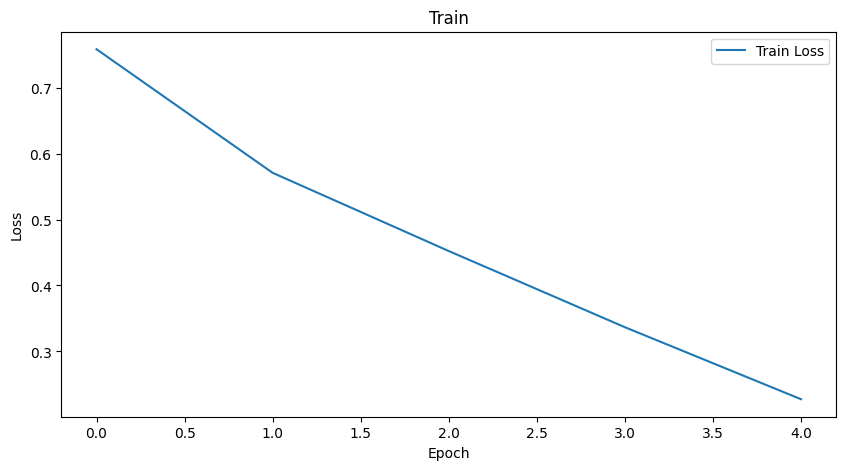

In [ ]:
# Plot loss
plt.figure(figsize=(10,5))
plt.plot(train_losses4, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Train')
plt.show()

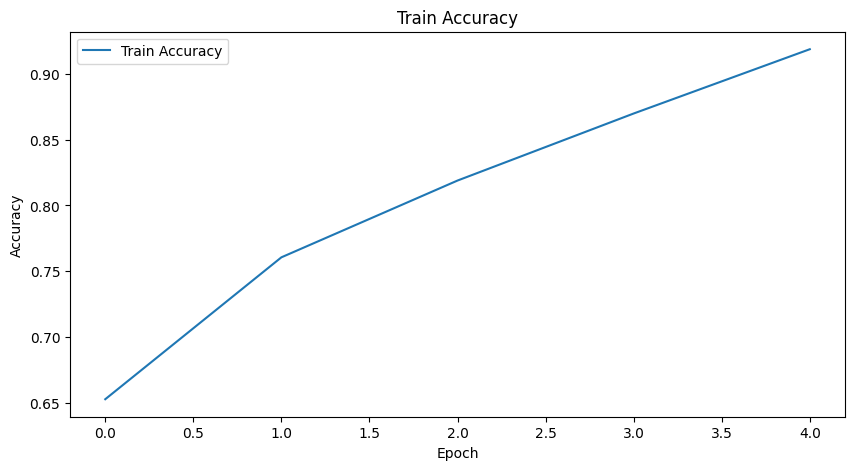

In [ ]:
# Plot akurasi
plt.figure(figsize=(10,5))
plt.plot(train_accuracies4, label='Train Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Train Accuracy')
plt.show()

In [ ]:
output_dir = '/content/drive/MyDrive/Skripsi/Piala_Asia/20rb/result/IndoBERT_Results/1'
os.makedirs(output_dir, exist_ok=True)

In [ ]:
# Simpan hasil prediksi ke CSV
all_texts = []

# Ulangi evaluasi untuk menyimpan teks, label, dan prediksi
model.eval()
torch.set_grad_enabled(False)

list_hyp, list_label = [], []
all_texts = []

test_pbar = tqdm(test_loader4, leave=True, total=len(test_loader4))  # atau test_loader2 untuk BERT
for i, batch_data in enumerate(test_pbar):
    loss, batch_hyp, batch_label = forward_sequence_classification(model, batch_data[:-1], i2w=i2w, device='cuda')

    list_hyp += batch_hyp
    list_label += batch_label
    batch_texts = batch_data[-1]  # bagian terakhir adalah teks asli
    all_texts += batch_texts

# Simpan ke dalam DataFrame dan CSV
df_result = pd.DataFrame({
    'text': all_texts,
    'true_label': list_label,
    'predicted_label': list_hyp
})

df_result.to_csv(os.path.join(output_dir,'hasil_prediksi_model4.csv'), index=False)  # Ganti ke model2 jika ingin simpan untuk BERT

test_metrics = document_sentiment_metrics_fn(list_hyp, list_label)
print(f'Test Metrics: {metrics_to_string(test_metrics)}')

100%|██████████| 108/108 [00:22<00:00,  4.74it/s]

Test Metrics: ACC:0.72 F1:0.71 REC:0.72 PRE:0.71


In [ ]:
# === SIMPAN METRIK PER EPOCH ===
df_metrics_epoch = pd.DataFrame({
    'epoch': list(range(1, len(train_losses4)+1)),
    'train_loss': train_losses4,
    'train_accuracy': train_accuracies4,
    'valid_loss': valid_losses4,
    'valid_accuracy': valid_accuracies4
})
df_metrics_epoch.to_csv(os.path.join(output_dir,'metrics_per_epoch.csv'), index=False)

# === SIMPAN WAKTU DAN MEMORI ===
df_time_memory = pd.DataFrame({
    'model': ['IndoBERT'],
    'train_time_seconds': [indobert1_train_time],
    'peak_memory_MB': [indobert1_peak_memory]
})
df_time_memory.to_csv(os.path.join(output_dir,'time_memory.csv'), index=False)

# === SIMPAN METRIK TEST ===
test_metrics = document_sentiment_metrics_fn(list_hyp, list_label)
test_metrics_dict = {
    'model': 'IndoBERT',
    **test_metrics
}
df_test_metrics = pd.DataFrame([test_metrics_dict])
df_test_metrics.to_csv(os.path.join(output_dir,'test_metrics.csv'), index=False)

# === SIMPAN CLASSIFICATION REPORT ===
report_dict = classification_report(list_label, list_hyp, output_dict=True, zero_division=0)
df_report = pd.DataFrame(report_dict).transpose()
df_report.to_csv(os.path.join(output_dir,'classification_report.csv'))

In [ ]:
# classification report
print(classification_report(list_label, list_hyp))

              precision    recall  f1-score   support

    negative       0.67      0.67      0.67       903
     neutral       0.69      0.61      0.65      1256
    positive       0.78      0.87      0.82      1271

    accuracy                           0.72      3430
   macro avg       0.71      0.72      0.71      3430
weighted avg       0.72      0.72      0.72      3430



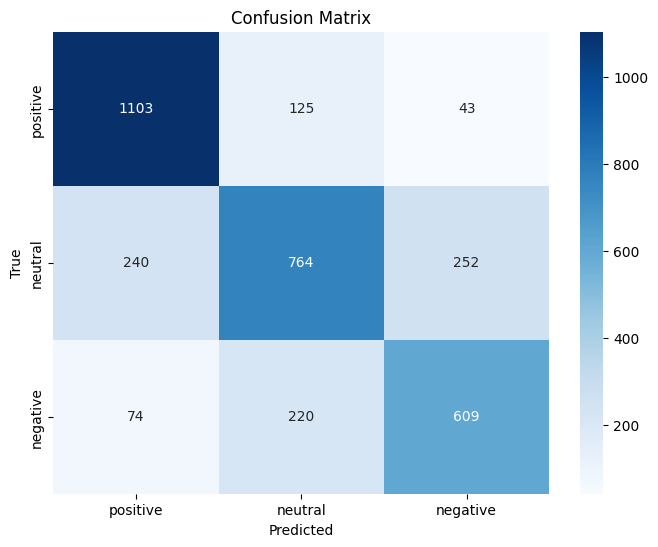

In [ ]:
# === SIMPAN CONFUSION MATRIX ===
labels = list(w2i.keys())
cm = confusion_matrix(list_label, list_hyp, labels=labels)
df_conf_matrix = pd.DataFrame(cm, index=[f"True_{l}" for l in labels], columns=[f"Pred_{l}" for l in labels])
df_conf_matrix.to_csv(os.path.join(output_dir,'confusion_matrix.csv'))

# === TAMPILKAN CONFUSION MATRIX ===
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.savefig(os.path.join(output_dir, 'confusion_matrix.png'))
plt.show()

In [ ]:
text = 'rafael mainnya jelek sekali'
subwords = tokenizer4.encode(text)
subwords = torch.LongTensor(subwords).view(1, -1).to(model4.device)

logits = model4(subwords)[0]
label = torch.topk(logits, k=1, dim=-1)[1].squeeze().item()

print(f'Text: {text} | Label : {i2w[label]} ({F.softmax(logits, dim=-1).squeeze()[label] * 100:.3f}%)')

Text: rafael mainnya jelek sekali | Label : negative (94.402%)


In [ ]:
text = 'sty stay'
subwords = tokenizer4.encode(text)
subwords = torch.LongTensor(subwords).view(1, -1).to(model4.device)

logits = model4(subwords)[0]
label = torch.topk(logits, k=1, dim=-1)[1].squeeze().item()

print(f'Text: {text} | Label : {i2w[label]} ({F.softmax(logits, dim=-1).squeeze()[label] * 100:.3f}%)')

Text: sty stay | Label : positive (98.981%)


### Learning Rate 3e-6

In [ ]:
tokenizer5 = BertTokenizer.from_pretrained('indobenchmark/indobert-large-p1')
config5 = BertConfig.from_pretrained('indobenchmark/indobert-large-p1')
config5.num_labels = DocumentSentimentDataset.NUM_LABELS
model5 = BertForSequenceClassification.from_pretrained('indobenchmark/indobert-large-p1', config=config5)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/229k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-large-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
model5

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 1024, padding_idx=0)
      (position_embeddings): Embedding(512, 1024)
      (token_type_embeddings): Embedding(2, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-23): 24 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (LayerNorm): LayerNorm((1

In [ ]:
train_dataset5 = DocumentSentimentDataset(train_dataset_path, tokenizer5, lowercase=True)
valid_dataset5 = DocumentSentimentDataset(valid_dataset_path, tokenizer5, lowercase=True)
test_dataset5 = DocumentSentimentDataset(test_dataset_path, tokenizer5, lowercase=True)

train_loader5 = DocumentSentimentDataLoader(dataset=train_dataset5, max_seq_len=512, batch_size=32, num_workers=2, shuffle=True)
valid_loader5 = DocumentSentimentDataLoader(dataset=valid_dataset5, max_seq_len=512, batch_size=32, num_workers=2, shuffle=False)
test_loader5 = DocumentSentimentDataLoader(dataset=test_dataset5, max_seq_len=512, batch_size=32, num_workers=2, shuffle=False)

In [ ]:
w2i, i2w = DocumentSentimentDataset.LABEL2INDEX, DocumentSentimentDataset.INDEX2LABEL
print(w2i)
print(i2w)

{'positive': 0, 'neutral': 1, 'negative': 2}
{0: 'positive', 1: 'neutral', 2: 'negative'}


In [ ]:
text = 'bacot'
subwords = tokenizer5.encode(text)
subwords = torch.LongTensor(subwords).view(1, -1).to(model5.device)

logits = model5(subwords)[0]
label = torch.topk(logits, k=1, dim=-1)[1].squeeze().item()

print(f'Text: {text} | Label : {i2w[label]} ({F.softmax(logits, dim=-1).squeeze()[label] * 100:.3f}%)')

Text: bacot | Label : positive (39.643%)


In [ ]:
text = 'taktik pelatih sty bagus'
subwords = tokenizer5.encode(text)
subwords = torch.LongTensor(subwords).view(1, -1).to(model5.device)

logits = model5(subwords)[0]
label = torch.topk(logits, k=1, dim=-1)[1].squeeze().item()

print(f'Text: {text} | Label : {i2w[label]} ({F.softmax(logits, dim=-1).squeeze()[label] * 100:.3f}%)')

Text: taktik pelatih sty bagus | Label : negative (37.579%)


In [ ]:
optimizer = optim.Adam(model5.parameters(), lr=3e-6)
model = model5.cuda()

In [ ]:
# Metrik penyimpanan untuk model kedua
train_losses5, train_accuracies5 = [], []
valid_losses5, valid_accuracies5 = [], []

# Early stopping
patience = 3
best_valid_loss = float('inf')
best_model_state = None
counter = 0

torch.cuda.reset_peak_memory_stats()
start_time = time.time()

n_epochs = 15

for epoch in range(n_epochs):
    print(f"\nEpoch {epoch+1}/{n_epochs}")

    # === TRAINING ===
    model.train()
    torch.set_grad_enabled(True)

    total_train_loss = 0
    list_hyp, list_label = [], []

    train_pbar = tqdm(train_loader5, desc=f"Training Epoch {epoch+1}", leave=True)
    for i, batch_data in enumerate(train_pbar):
        loss, batch_hyp, batch_label = forward_sequence_classification(model, batch_data[:-1], i2w=i2w, device='cuda')
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
        list_hyp += batch_hyp
        list_label += batch_label

    train_metrics = document_sentiment_metrics_fn(list_hyp, list_label)
    avg_train_loss = total_train_loss / len(train_loader5)
    train_losses5.append(avg_train_loss)
    train_accuracies5.append(train_metrics['ACC'])

    # === VALIDATION ===
    model.eval()
    torch.set_grad_enabled(False)

    total_valid_loss = 0
    list_hyp_valid, list_label_valid = [], []

    valid_pbar = tqdm(valid_loader5, desc=f"Validating Epoch {epoch+1}", leave=True)
    for batch_data in valid_pbar:
        loss, batch_hyp, batch_label = forward_sequence_classification(model, batch_data[:-1], i2w=i2w, device='cuda')
        total_valid_loss += loss.item()
        list_hyp_valid += batch_hyp
        list_label_valid += batch_label

    valid_metrics = document_sentiment_metrics_fn(list_hyp_valid, list_label_valid)
    avg_valid_loss = total_valid_loss / len(valid_loader5)
    valid_losses5.append(avg_valid_loss)
    valid_accuracies5.append(valid_metrics['ACC'])

    print(f"Epoch {epoch+1}/{n_epochs} | "
          f"Train Loss: {avg_train_loss:.4f} | Train Acc: {train_metrics['ACC']:.4f} | "
          f"Valid Loss: {avg_valid_loss:.4f} | Valid Acc: {valid_metrics['ACC']:.4f}")

    # === EARLY STOPPING ===
    if avg_valid_loss < best_valid_loss:
        best_valid_loss = avg_valid_loss
        best_model_state = copy.deepcopy(model.state_dict())
        counter = 0
    else:
        counter += 1
        print(f"Valid loss tidak membaik selama {counter} epoch berturut-turut.")
        if counter >= patience:
            print(f"Early stopping aktif di epoch {epoch+1}. Training dihentikan.")
            break

# Load model terbaik
if best_model_state is not None:
    model.load_state_dict(best_model_state)

end_time = time.time()
indobert2_train_time = end_time - start_time
indobert2_peak_memory = torch.cuda.max_memory_allocated() / 1024**2

print(f"\nIndoBERT2 - Waktu training: {indobert2_train_time:.2f} detik | Peak memory: {indobert2_peak_memory:.2f} MB")



Epoch 1/15


Validating Epoch 1: 100%|██████████| 86/86 [00:16<00:00,  5.14it/s]


Epoch 1/15 | Train Loss: 0.8413 | Train Acc: 0.6041 | Valid Loss: 0.7021 | Valid Acc: 0.6888

Epoch 2/15


Validating Epoch 2: 100%|██████████| 86/86 [00:16<00:00,  5.16it/s]


Epoch 2/15 | Train Loss: 0.6561 | Train Acc: 0.7141 | Valid Loss: 0.6611 | Valid Acc: 0.7190

Epoch 3/15


Validating Epoch 3: 100%|██████████| 86/86 [00:16<00:00,  5.19it/s]


Epoch 3/15 | Train Loss: 0.5752 | Train Acc: 0.7564 | Valid Loss: 0.6432 | Valid Acc: 0.7310

Epoch 4/15


Validating Epoch 4: 100%|██████████| 86/86 [00:16<00:00,  5.17it/s]


Epoch 4/15 | Train Loss: 0.5064 | Train Acc: 0.7915 | Valid Loss: 0.6516 | Valid Acc: 0.7362
Valid loss tidak membaik selama 1 epoch berturut-turut.

Epoch 5/15


Validating Epoch 5: 100%|██████████| 86/86 [00:16<00:00,  5.15it/s]


Epoch 5/15 | Train Loss: 0.4484 | Train Acc: 0.8216 | Valid Loss: 0.6833 | Valid Acc: 0.7343
Valid loss tidak membaik selama 2 epoch berturut-turut.

Epoch 6/15


Validating Epoch 6: 100%|██████████| 86/86 [00:16<00:00,  5.18it/s]


Epoch 6/15 | Train Loss: 0.3954 | Train Acc: 0.8487 | Valid Loss: 0.6875 | Valid Acc: 0.7394
Valid loss tidak membaik selama 3 epoch berturut-turut.
Early stopping aktif di epoch 6. Training dihentikan.

IndoBERT2 - Waktu training: 1368.38 detik | Peak memory: 11242.44 MB


In [ ]:
!nvidia-smi

Sun May 18 14:23:39 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   73C    P0             31W /   70W |   12298MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

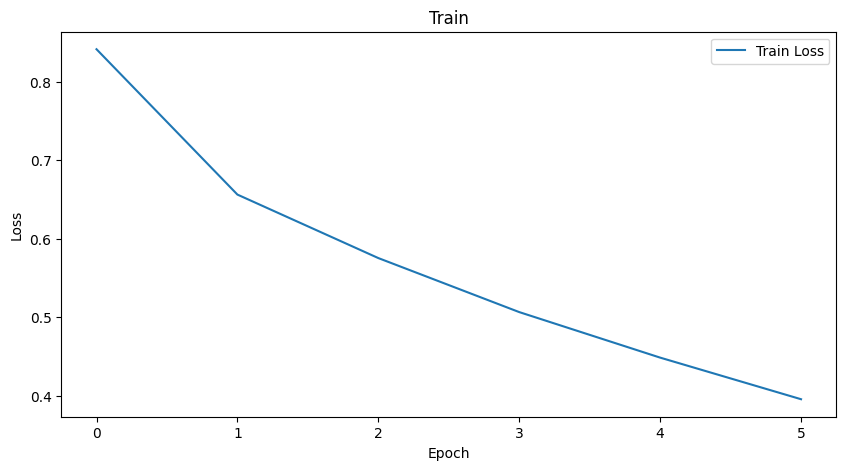

In [ ]:
# Plot loss
plt.figure(figsize=(10,5))
plt.plot(train_losses5, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Train')
plt.show()

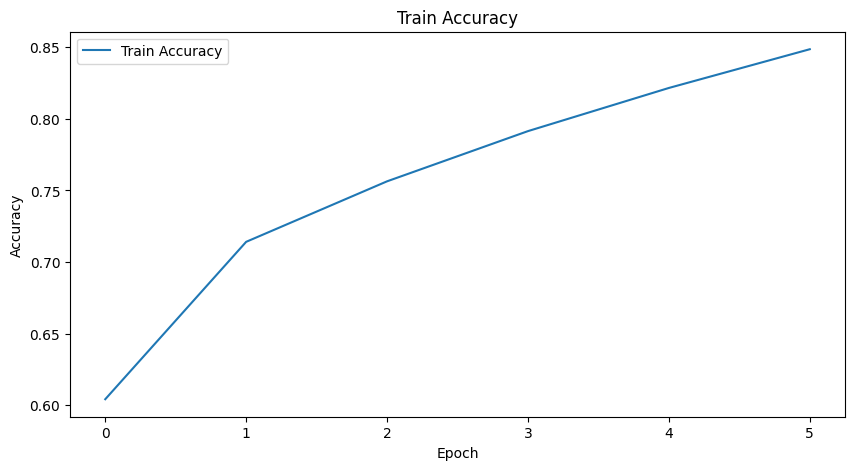

In [ ]:
# Plot akurasi
plt.figure(figsize=(10,5))
plt.plot(train_accuracies5, label='Train Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Train Accuracy')
plt.show()

In [ ]:
output_dir = '/content/drive/MyDrive/Skripsi/Piala_Asia/20rb/result/IndoBERT_Results/2'
os.makedirs(output_dir, exist_ok=True)

In [ ]:
# Simpan hasil prediksi ke CSV
all_texts = []

# Ulangi evaluasi untuk menyimpan teks, label, dan prediksi
model.eval()
torch.set_grad_enabled(False)

list_hyp, list_label = [], []
all_texts = []

test_pbar = tqdm(test_loader5, leave=True, total=len(test_loader5))  # atau test_loader2 untuk BERT
for i, batch_data in enumerate(test_pbar):
    loss, batch_hyp, batch_label = forward_sequence_classification(model, batch_data[:-1], i2w=i2w, device='cuda')

    list_hyp += batch_hyp
    list_label += batch_label
    batch_texts = batch_data[-1]  # bagian terakhir adalah teks asli
    all_texts += batch_texts

# Simpan ke dalam DataFrame dan CSV
df_result = pd.DataFrame({
    'text': all_texts,
    'true_label': list_label,
    'predicted_label': list_hyp
})

df_result.to_csv(os.path.join(output_dir,'hasil_prediksi_model5.csv'), index=False)  # Ganti ke model2 jika ingin simpan untuk BERT

test_metrics = document_sentiment_metrics_fn(list_hyp, list_label)
print(f'Test Metrics: {metrics_to_string(test_metrics)}')

100%|██████████| 108/108 [00:21<00:00,  5.01it/s]

Test Metrics: ACC:0.73 F1:0.72 REC:0.72 PRE:0.73


In [ ]:
# === SIMPAN METRIK PER EPOCH ===
df_metrics_epoch = pd.DataFrame({
    'epoch': list(range(1, len(train_losses5)+1)),
    'train_loss': train_losses5,
    'train_accuracy': train_accuracies5,
    'valid_loss': valid_losses5,
    'valid_accuracy': valid_accuracies5
})
df_metrics_epoch.to_csv(os.path.join(output_dir,'metrics_per_epoch.csv'), index=False)

# === SIMPAN WAKTU DAN MEMORI ===
df_time_memory = pd.DataFrame({
    'model': ['IndoBERT'],
    'train_time_seconds': [indobert2_train_time],
    'peak_memory_MB': [indobert2_peak_memory]
})
df_time_memory.to_csv(os.path.join(output_dir,'time_memory.csv'), index=False)

# === SIMPAN METRIK TEST ===
test_metrics = document_sentiment_metrics_fn(list_hyp, list_label)
test_metrics_dict = {
    'model': 'IndoBERT',
    **test_metrics
}
df_test_metrics = pd.DataFrame([test_metrics_dict])
df_test_metrics.to_csv(os.path.join(output_dir,'test_metrics.csv'), index=False)

# === SIMPAN CLASSIFICATION REPORT ===
report_dict = classification_report(list_label, list_hyp, output_dict=True, zero_division=0)
df_report = pd.DataFrame(report_dict).transpose()
df_report.to_csv(os.path.join(output_dir,'classification_report.csv'))

In [ ]:
# classification report
print(classification_report(list_label, list_hyp))

              precision    recall  f1-score   support

    negative       0.68      0.63      0.65       903
     neutral       0.66      0.70      0.68      1256
    positive       0.83      0.84      0.84      1271

    accuracy                           0.73      3430
   macro avg       0.73      0.72      0.72      3430
weighted avg       0.73      0.73      0.73      3430



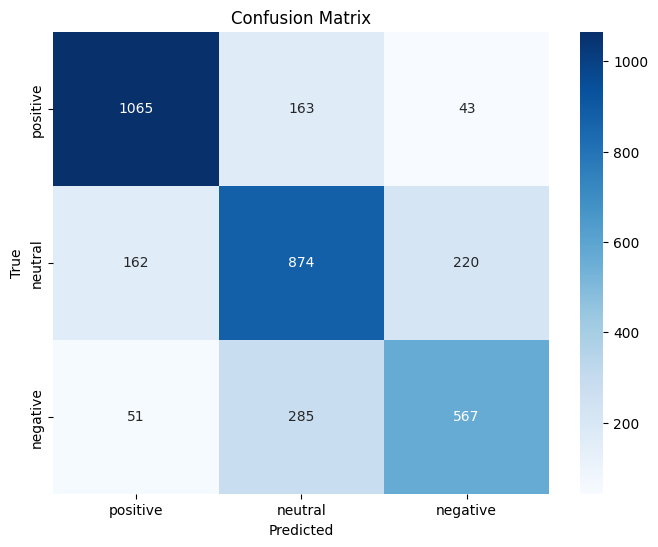

In [ ]:
# === SIMPAN CONFUSION MATRIX ===
labels = list(w2i.keys())
cm = confusion_matrix(list_label, list_hyp, labels=labels)
df_conf_matrix = pd.DataFrame(cm, index=[f"True_{l}" for l in labels], columns=[f"Pred_{l}" for l in labels])
df_conf_matrix.to_csv(os.path.join(output_dir,'confusion_matrix.csv'))

# === TAMPILKAN CONFUSION MATRIX ===
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.savefig(os.path.join(output_dir, 'confusion_matrix.png'))
plt.show()

In [ ]:
text = 'rafael mainnya jelek sekali'
subwords = tokenizer5.encode(text)
subwords = torch.LongTensor(subwords).view(1, -1).to(model5.device)

logits = model5(subwords)[0]
label = torch.topk(logits, k=1, dim=-1)[1].squeeze().item()

print(f'Text: {text} | Label : {i2w[label]} ({F.softmax(logits, dim=-1).squeeze()[label] * 100:.3f}%)')

Text: rafael mainnya jelek sekali | Label : negative (90.449%)


In [ ]:
text = 'sty stay'
subwords = tokenizer5.encode(text)
subwords = torch.LongTensor(subwords).view(1, -1).to(model5.device)

logits = model5(subwords)[0]
label = torch.topk(logits, k=1, dim=-1)[1].squeeze().item()

print(f'Text: {text} | Label : {i2w[label]} ({F.softmax(logits, dim=-1).squeeze()[label] * 100:.3f}%)')

Text: sty stay | Label : positive (98.506%)


### Learning Rate 5e-5

In [ ]:
tokenizer6 = BertTokenizer.from_pretrained('indobenchmark/indobert-large-p1')
config6 = BertConfig.from_pretrained('indobenchmark/indobert-large-p1')
config6.num_labels = DocumentSentimentDataset.NUM_LABELS
model6 = BertForSequenceClassification.from_pretrained('indobenchmark/indobert-large-p1', config=config6)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-large-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
model6

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 1024, padding_idx=0)
      (position_embeddings): Embedding(512, 1024)
      (token_type_embeddings): Embedding(2, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-23): 24 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (LayerNorm): LayerNorm((1

In [ ]:
train_dataset6 = DocumentSentimentDataset(train_dataset_path, tokenizer6, lowercase=True)
valid_dataset6 = DocumentSentimentDataset(valid_dataset_path, tokenizer6, lowercase=True)
test_dataset6 = DocumentSentimentDataset(test_dataset_path, tokenizer6, lowercase=True)

train_loader6 = DocumentSentimentDataLoader(dataset=train_dataset6, max_seq_len=512, batch_size=32, num_workers=2, shuffle=True)
valid_loader6 = DocumentSentimentDataLoader(dataset=valid_dataset6, max_seq_len=512, batch_size=32, num_workers=2, shuffle=False)
test_loader6 = DocumentSentimentDataLoader(dataset=test_dataset6, max_seq_len=512, batch_size=32, num_workers=2, shuffle=False)

In [ ]:
w2i, i2w = DocumentSentimentDataset.LABEL2INDEX, DocumentSentimentDataset.INDEX2LABEL
print(w2i)
print(i2w)

{'positive': 0, 'neutral': 1, 'negative': 2}
{0: 'positive', 1: 'neutral', 2: 'negative'}


In [ ]:
text = 'bacot'
subwords = tokenizer6.encode(text)
subwords = torch.LongTensor(subwords).view(1, -1).to(model6.device)

logits = model6(subwords)[0]
label = torch.topk(logits, k=1, dim=-1)[1].squeeze().item()

print(f'Text: {text} | Label : {i2w[label]} ({F.softmax(logits, dim=-1).squeeze()[label] * 100:.3f}%)')

Text: bacot | Label : positive (46.429%)


In [ ]:
text = 'taktik pelatih sty bagus'
subwords = tokenizer6.encode(text)
subwords = torch.LongTensor(subwords).view(1, -1).to(model6.device)

logits = model6(subwords)[0]
label = torch.topk(logits, k=1, dim=-1)[1].squeeze().item()

print(f'Text: {text} | Label : {i2w[label]} ({F.softmax(logits, dim=-1).squeeze()[label] * 100:.3f}%)')

Text: taktik pelatih sty bagus | Label : positive (43.651%)


In [ ]:
optimizer = optim.Adam(model6.parameters(), lr=5e-5)
model = model6.cuda()

In [ ]:
# Metrik penyimpanan untuk model kedua
train_losses6, train_accuracies6 = [], []
valid_losses6, valid_accuracies6 = [], []

# Early stopping
patience = 3
best_valid_loss = float('inf')
best_model_state = None
counter = 0

torch.cuda.reset_peak_memory_stats()
start_time = time.time()

n_epochs = 15

for epoch in range(n_epochs):
    print(f"\nEpoch {epoch+1}/{n_epochs}")

    # === TRAINING ===
    model.train()
    torch.set_grad_enabled(True)

    total_train_loss = 0
    list_hyp, list_label = [], []

    train_pbar = tqdm(train_loader6, desc=f"Training Epoch {epoch+1}", leave=True)
    for i, batch_data in enumerate(train_pbar):
        loss, batch_hyp, batch_label = forward_sequence_classification(model, batch_data[:-1], i2w=i2w, device='cuda')
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
        list_hyp += batch_hyp
        list_label += batch_label

    train_metrics = document_sentiment_metrics_fn(list_hyp, list_label)
    avg_train_loss = total_train_loss / len(train_loader6)
    train_losses6.append(avg_train_loss)
    train_accuracies6.append(train_metrics['ACC'])

    # === VALIDATION ===
    model.eval()
    torch.set_grad_enabled(False)

    total_valid_loss = 0
    list_hyp_valid, list_label_valid = [], []

    valid_pbar = tqdm(valid_loader6, desc=f"Validating Epoch {epoch+1}", leave=True)
    for batch_data in valid_pbar:
        loss, batch_hyp, batch_label = forward_sequence_classification(model, batch_data[:-1], i2w=i2w, device='cuda')
        total_valid_loss += loss.item()
        list_hyp_valid += batch_hyp
        list_label_valid += batch_label

    valid_metrics = document_sentiment_metrics_fn(list_hyp_valid, list_label_valid)
    avg_valid_loss = total_valid_loss / len(valid_loader6)
    valid_losses6.append(avg_valid_loss)
    valid_accuracies6.append(valid_metrics['ACC'])

    print(f"Epoch {epoch+1}/{n_epochs} | "
          f"Train Loss: {avg_train_loss:.4f} | Train Acc: {train_metrics['ACC']:.4f} | "
          f"Valid Loss: {avg_valid_loss:.4f} | Valid Acc: {valid_metrics['ACC']:.4f}")

    # === EARLY STOPPING ===
    if avg_valid_loss < best_valid_loss:
        best_valid_loss = avg_valid_loss
        best_model_state = copy.deepcopy(model.state_dict())
        counter = 0
    else:
        counter += 1
        print(f"Valid loss tidak membaik selama {counter} epoch berturut-turut.")
        if counter >= patience:
            print(f"Early stopping aktif di epoch {epoch+1}. Training dihentikan.")
            break

# Load model terbaik
if best_model_state is not None:
    model.load_state_dict(best_model_state)

end_time = time.time()
indobert6_train_time = end_time - start_time
indobert6_peak_memory = torch.cuda.max_memory_allocated() / 1024**2

print(f"\nIndoBERT3 - Waktu training: {indobert6_train_time:.2f} detik | Peak memory: {indobert6_peak_memory:.2f} MB")



Epoch 1/15


Validating Epoch 1: 100%|██████████| 86/86 [00:16<00:00,  5.12it/s]


Epoch 1/15 | Train Loss: 0.6877 | Train Acc: 0.6937 | Valid Loss: 0.6143 | Valid Acc: 0.7372

Epoch 2/15


Validating Epoch 2: 100%|██████████| 86/86 [00:16<00:00,  5.15it/s]


Epoch 2/15 | Train Loss: 0.4685 | Train Acc: 0.8107 | Valid Loss: 0.6319 | Valid Acc: 0.7445
Valid loss tidak membaik selama 1 epoch berturut-turut.

Epoch 3/15


Validating Epoch 3: 100%|██████████| 86/86 [00:16<00:00,  5.22it/s]


Epoch 3/15 | Train Loss: 0.2831 | Train Acc: 0.8936 | Valid Loss: 0.7908 | Valid Acc: 0.7307
Valid loss tidak membaik selama 2 epoch berturut-turut.

Epoch 4/15


Validating Epoch 4: 100%|██████████| 86/86 [00:16<00:00,  5.14it/s]

Epoch 4/15 | Train Loss: 0.1930 | Train Acc: 0.9253 | Valid Loss: 0.9909 | Valid Acc: 0.7270
Valid loss tidak membaik selama 3 epoch berturut-turut.
Early stopping aktif di epoch 4. Training dihentikan.

IndoBERT3 - Waktu training: 917.15 detik | Peak memory: 13816.08 MB


In [ ]:
!nvidia-smi

Sun May 18 14:40:57 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   70C    P0             31W /   70W |   14442MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

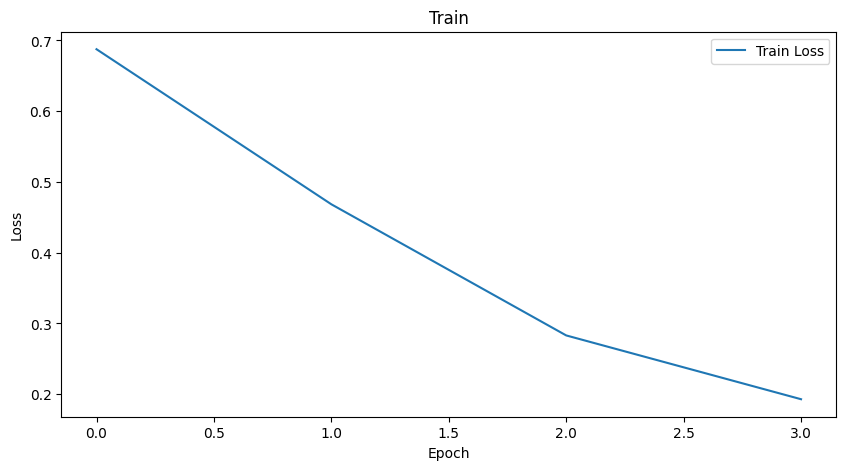

In [ ]:
# Plot loss
plt.figure(figsize=(10,5))
plt.plot(train_losses6, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Train')
plt.show()

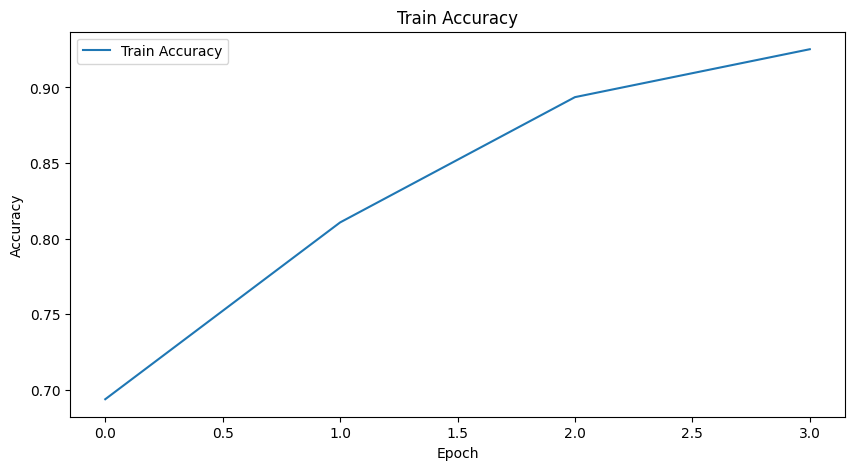

In [ ]:
# Plot akurasi
plt.figure(figsize=(10,5))
plt.plot(train_accuracies6, label='Train Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Train Accuracy')
plt.show()

In [ ]:
output_dir = '/content/drive/MyDrive/Skripsi/Piala_Asia/20rb/result/IndoBERT_Results/3'
os.makedirs(output_dir, exist_ok=True)

In [ ]:
# Simpan hasil prediksi ke CSV
all_texts = []

# Ulangi evaluasi untuk menyimpan teks, label, dan prediksi
model.eval()
torch.set_grad_enabled(False)

list_hyp, list_label = [], []
all_texts = []

test_pbar = tqdm(test_loader6, leave=True, total=len(test_loader6))  # atau test_loader2 untuk BERT
for i, batch_data in enumerate(test_pbar):
    loss, batch_hyp, batch_label = forward_sequence_classification(model, batch_data[:-1], i2w=i2w, device='cuda')

    list_hyp += batch_hyp
    list_label += batch_label
    batch_texts = batch_data[-1]  # bagian terakhir adalah teks asli
    all_texts += batch_texts

# Simpan ke dalam DataFrame dan CSV
df_result = pd.DataFrame({
    'text': all_texts,
    'true_label': list_label,
    'predicted_label': list_hyp
})

df_result.to_csv(os.path.join(output_dir,'hasil_prediksi_model6.csv'), index=False)  # Ganti ke model2 jika ingin simpan untuk BERT

test_metrics = document_sentiment_metrics_fn(list_hyp, list_label)
print(f'Test Metrics: {metrics_to_string(test_metrics)}')

100%|██████████| 108/108 [00:21<00:00,  5.05it/s]

Test Metrics: ACC:0.74 F1:0.72 REC:0.72 PRE:0.75


In [ ]:
# === SIMPAN METRIK PER EPOCH ===
df_metrics_epoch = pd.DataFrame({
    'epoch': list(range(1, len(train_losses6)+1)),
    'train_loss': train_losses6,
    'train_accuracy': train_accuracies6,
    'valid_loss': valid_losses6,
    'valid_accuracy': valid_accuracies6
})
df_metrics_epoch.to_csv(os.path.join(output_dir,'metrics_per_epoch.csv'), index=False)

# === SIMPAN WAKTU DAN MEMORI ===
df_time_memory = pd.DataFrame({
    'model': ['IndoBERT'],
    'train_time_seconds': [indobert6_train_time],
    'peak_memory_MB': [indobert6_peak_memory]
})
df_time_memory.to_csv(os.path.join(output_dir,'time_memory.csv'), index=False)

# === SIMPAN METRIK TEST ===
test_metrics = document_sentiment_metrics_fn(list_hyp, list_label)
test_metrics_dict = {
    'model': 'IndoBERT',
    **test_metrics
}
df_test_metrics = pd.DataFrame([test_metrics_dict])
df_test_metrics.to_csv(os.path.join(output_dir,'test_metrics.csv'), index=False)

# === SIMPAN CLASSIFICATION REPORT ===
report_dict = classification_report(list_label, list_hyp, output_dict=True, zero_division=0)
df_report = pd.DataFrame(report_dict).transpose()
df_report.to_csv(os.path.join(output_dir,'classification_report.csv'))

In [ ]:
# classification report
print(classification_report(list_label, list_hyp))

              precision    recall  f1-score   support

    negative       0.74      0.54      0.63       903
     neutral       0.63      0.79      0.71      1256
    positive       0.87      0.82      0.84      1271

    accuracy                           0.74      3430
   macro avg       0.75      0.72      0.72      3430
weighted avg       0.75      0.74      0.73      3430



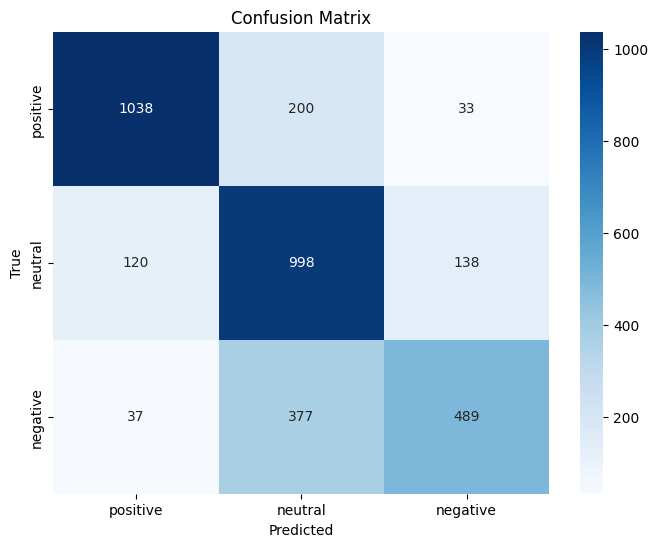

In [ ]:
# === SIMPAN CONFUSION MATRIX ===
labels = list(w2i.keys())
cm = confusion_matrix(list_label, list_hyp, labels=labels)
df_conf_matrix = pd.DataFrame(cm, index=[f"True_{l}" for l in labels], columns=[f"Pred_{l}" for l in labels])
df_conf_matrix.to_csv(os.path.join(output_dir,'confusion_matrix.csv'))

# === TAMPILKAN CONFUSION MATRIX ===
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.savefig(os.path.join(output_dir, 'confusion_matrix.png'))
plt.show()

In [ ]:
text = 'rafael mainnya jelek sekali'
subwords = tokenizer6.encode(text)
subwords = torch.LongTensor(subwords).view(1, -1).to(model6.device)

logits = model6(subwords)[0]
label = torch.topk(logits, k=1, dim=-1)[1].squeeze().item()

print(f'Text: {text} | Label : {i2w[label]} ({F.softmax(logits, dim=-1).squeeze()[label] * 100:.3f}%)')

Text: rafael mainnya jelek sekali | Label : negative (94.339%)


In [ ]:
text = 'sty stay'
subwords = tokenizer6.encode(text)
subwords = torch.LongTensor(subwords).view(1, -1).to(model6.device)

logits = model6(subwords)[0]
label = torch.topk(logits, k=1, dim=-1)[1].squeeze().item()

print(f'Text: {text} | Label : {i2w[label]} ({F.softmax(logits, dim=-1).squeeze()[label] * 100:.3f}%)')

Text: sty stay | Label : positive (97.756%)


## DistilBERT Multilingual

### Learning Rate 1e-5

In [ ]:
tokenizer7 = DistilBertTokenizer.from_pretrained('distilbert/distilbert-base-multilingual-cased')
config7 = DistilBertConfig.from_pretrained('distilbert/distilbert-base-multilingual-cased')
config7.num_labels = DocumentSentimentDataset.NUM_LABELS
model7 = DistilBertForSequenceClassification.from_pretrained('distilbert/distilbert-base-multilingual-cased', config=config7)


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/542M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
model7

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)

In [ ]:
count_param(model7)

135326979

In [ ]:
distilbert_param_count = count_param(model7, trainable=True)

In [ ]:
train_dataset7 = DocumentSentimentDataset(train_dataset_path, tokenizer7, lowercase=True)
valid_dataset7 = DocumentSentimentDataset(valid_dataset_path, tokenizer7, lowercase=True)
test_dataset7 = DocumentSentimentDataset(test_dataset_path, tokenizer7, lowercase=True)

train_loader7 = DocumentSentimentDataLoader(dataset=train_dataset7, max_seq_len=512, batch_size=32, num_workers=2, shuffle=True)
valid_loader7 = DocumentSentimentDataLoader(dataset=valid_dataset7, max_seq_len=512, batch_size=32, num_workers=2, shuffle=False)
test_loader7 = DocumentSentimentDataLoader(dataset=test_dataset7, max_seq_len=512, batch_size=32, num_workers=2, shuffle=False)

In [ ]:
w2i, i2w = DocumentSentimentDataset.LABEL2INDEX, DocumentSentimentDataset.INDEX2LABEL
print(w2i)
print(i2w)

{'positive': 0, 'neutral': 1, 'negative': 2}
{0: 'positive', 1: 'neutral', 2: 'negative'}


In [ ]:
text = 'bacot'
subwords = tokenizer7.encode(text)
subwords = torch.LongTensor(subwords).view(1, -1).to(model7.device)

logits = model7(subwords)[0]
label = torch.topk(logits, k=1, dim=-1)[1].squeeze().item()

print(f'Text: {text} | Label : {i2w[label]} ({F.softmax(logits, dim=-1).squeeze()[label] * 100:.3f}%)')

Text: bacot | Label : positive (35.712%)


In [ ]:
text = 'taktik pelatih sty bagus'
subwords = tokenizer7.encode(text)
subwords = torch.LongTensor(subwords).view(1, -1).to(model7.device)

logits = model7(subwords)[0]
label = torch.topk(logits, k=1, dim=-1)[1].squeeze().item()

print(f'Text: {text} | Label : {i2w[label]} ({F.softmax(logits, dim=-1).squeeze()[label] * 100:.3f}%)')

Text: taktik pelatih sty bagus | Label : positive (36.469%)


In [ ]:
optimizer = optim.Adam(model7.parameters(), lr=1e-5)
model = model7.cuda()

In [ ]:
# Metrik penyimpanan untuk model keempat
train_losses7, train_accuracies7 = [], []
valid_losses7, valid_accuracies7 = [], []

# Early stopping
patience = 3
best_valid_loss = float('inf')
best_model_state = None
counter = 0

torch.cuda.reset_peak_memory_stats()
start_time = time.time()

n_epochs = 15

for epoch in range(n_epochs):
    print(f"\nEpoch {epoch+1}/{n_epochs}")

    # === TRAINING ===
    model.train()
    torch.set_grad_enabled(True)

    total_train_loss = 0
    list_hyp, list_label = [], []

    train_pbar = tqdm(train_loader7, desc=f"Training Epoch {epoch+1}", leave=True)
    for i, batch_data in enumerate(train_pbar):
        batch_inputs = {
            "input_ids": torch.tensor(batch_data[0]).to(model.device),
            "attention_mask": torch.tensor(batch_data[1]).to(model.device),
        }
        if len(batch_data) > 2:
            batch_inputs["labels"] = torch.tensor(batch_data[2]).to(model.device)

        outputs = model(**batch_inputs)
        loss = outputs.loss
        logits = outputs.logits

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()

        batch_hyp = torch.argmax(logits, dim=1).cpu().tolist()
        batch_label = batch_inputs["labels"].cpu().tolist()

        id2label = {0: 'positive', 1: 'neutral', 2: 'negative'}
        # Fix: Access the first element of the list in batch_hyp and batch_label
        list_hyp_str = [id2label[i] for i in batch_hyp]
        list_label_str = [id2label[i[0]] for i in batch_label] # Changed to access the first element

        list_hyp.extend(list_hyp_str)
        list_label.extend(list_label_str)

    train_metrics = document_sentiment_metrics_fn(list_hyp, list_label)
    avg_train_loss = total_train_loss / len(train_loader7)
    train_losses7.append(avg_train_loss)
    train_accuracies7.append(train_metrics['ACC'])

    # === VALIDATION ===
    model.eval()
    torch.set_grad_enabled(False)

    total_valid_loss = 0
    list_hyp_valid, list_label_valid = [], []

    valid_pbar = tqdm(valid_loader7, desc=f"Validating Epoch {epoch+1}", leave=True)
    for batch_data in valid_pbar:
        batch_inputs = {
            "input_ids": torch.tensor(batch_data[0]).to(model.device),
            "attention_mask": torch.tensor(batch_data[1]).to(model.device),
        }
        if len(batch_data) > 2:
            batch_inputs["labels"] = torch.tensor(batch_data[2]).to(model.device)

        outputs = model(**batch_inputs)
        loss = outputs.loss
        logits = outputs.logits

        total_valid_loss += loss.item()

        batch_hyp = torch.argmax(logits, dim=1).cpu().tolist()
        batch_label = batch_inputs["labels"].cpu().tolist()

        # Fix: Access the first element of the list in batch_hyp_valid and batch_label_valid
        list_hyp_valid += [id2label[i] for i in batch_hyp]
        list_label_valid += [id2label[i[0]] for i in batch_label] # Changed to access the first element

    valid_metrics = document_sentiment_metrics_fn(list_hyp_valid, list_label_valid)
    avg_valid_loss = total_valid_loss / len(valid_loader7)
    valid_losses7.append(avg_valid_loss)
    valid_accuracies7.append(valid_metrics['ACC'])

    print(f"Epoch {epoch+1}/{n_epochs} | "
          f"Train Loss: {avg_train_loss:.4f} | Train Acc: {train_metrics['ACC']:.4f} | "
          f"Valid Loss: {avg_valid_loss:.4f} | Valid Acc: {valid_metrics['ACC']:.4f}")

    # === EARLY STOPPING ===
    if avg_valid_loss < best_valid_loss:
        best_valid_loss = avg_valid_loss
        best_model_state = copy.deepcopy(model.state_dict())
        counter = 0
    else:
        counter += 1
        print(f"Valid loss tidak membaik selama {counter} epoch berturut-turut.")
        if counter >= patience:
            print(f"Early stopping aktif di epoch {epoch+1}. Training dihentikan.")
            break

# Load model terbaik
if best_model_state is not None:
    model.load_state_dict(best_model_state)

end_time = time.time()
distilbert1_train_time = end_time - start_time
distilbert1_peak_memory = torch.cuda.max_memory_allocated() / 1024**2

print(f"\nDistilBERT1 - Waktu training: {distilbert1_train_time:.2f} detik | Peak memory: {distilbert1_peak_memory:.2f} MB")


Epoch 1/15


Validating Epoch 1: 100%|██████████| 86/86 [00:03<00:00, 23.13it/s]


Epoch 1/15 | Train Loss: 0.8817 | Train Acc: 0.5650 | Valid Loss: 0.7635 | Valid Acc: 0.6585

Epoch 2/15


Validating Epoch 2: 100%|██████████| 86/86 [00:04<00:00, 20.76it/s]


Epoch 2/15 | Train Loss: 0.6919 | Train Acc: 0.6925 | Valid Loss: 0.7173 | Valid Acc: 0.6808

Epoch 3/15


Validating Epoch 3: 100%|██████████| 86/86 [00:04<00:00, 17.31it/s]


Epoch 3/15 | Train Loss: 0.5942 | Train Acc: 0.7494 | Valid Loss: 0.7382 | Valid Acc: 0.6855
Valid loss tidak membaik selama 1 epoch berturut-turut.

Epoch 4/15


Validating Epoch 4: 100%|██████████| 86/86 [00:03<00:00, 22.13it/s]


Epoch 4/15 | Train Loss: 0.5118 | Train Acc: 0.7904 | Valid Loss: 0.7308 | Valid Acc: 0.7015
Valid loss tidak membaik selama 2 epoch berturut-turut.

Epoch 5/15


Validating Epoch 5: 100%|██████████| 86/86 [00:03<00:00, 22.81it/s]

Epoch 5/15 | Train Loss: 0.4278 | Train Acc: 0.8319 | Valid Loss: 0.7734 | Valid Acc: 0.6837
Valid loss tidak membaik selama 3 epoch berturut-turut.
Early stopping aktif di epoch 5. Training dihentikan.

DistilBERT1 - Waktu training: 288.98 detik | Peak memory: 9082.25 MB


In [ ]:
!nvidia-smi

Sun May 18 14:50:03 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   69C    P0             30W /   70W |    9688MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

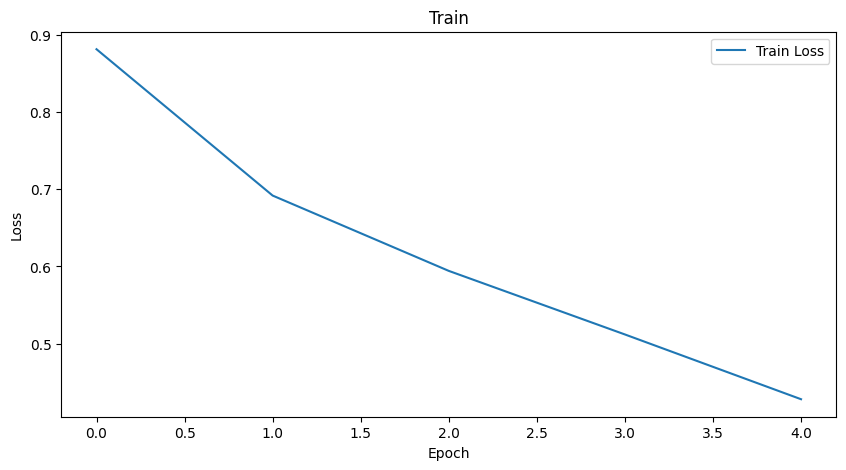

In [ ]:
# Plot loss
plt.figure(figsize=(10,5))
plt.plot(train_losses7, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Train')
plt.show()

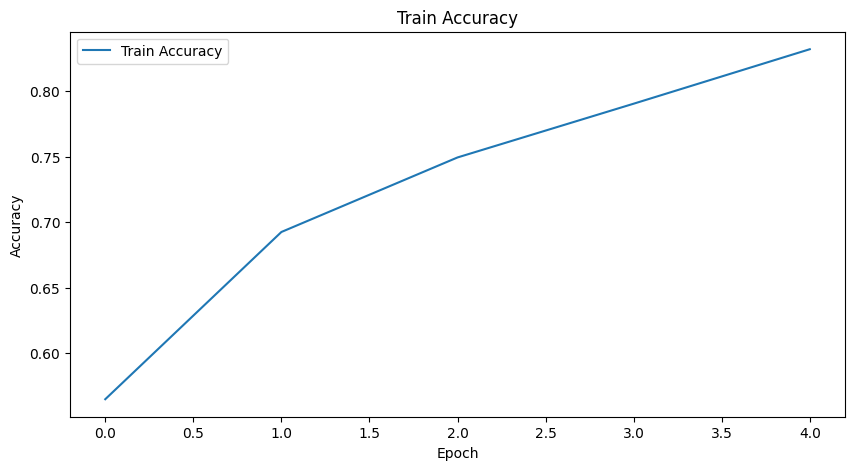

In [ ]:
# Plot akurasi
plt.figure(figsize=(10,5))
plt.plot(train_accuracies7, label='Train Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Train Accuracy')
plt.show()

In [ ]:
output_dir = '/content/drive/MyDrive/Skripsi/Piala_Asia/20rb/result/DistilBERT_Results/1'
os.makedirs(output_dir, exist_ok=True)

In [ ]:
# Simpan hasil prediksi ke CSV
all_texts = []

# Ulangi evaluasi untuk menyimpan teks, label, dan prediksi
model.eval()
torch.set_grad_enabled(False)

list_hyp, list_label = [], []
all_texts = []
total_test_loss = 0 # Initialize total_test_loss here

test_pbar = tqdm(test_loader7, leave=True, total=len(test_loader7))
for i, batch_data in enumerate(test_pbar):
    batch_inputs = {
        "input_ids": torch.tensor(batch_data[0]).to(model.device),
        "attention_mask": torch.tensor(batch_data[1]).to(model.device),
    }

    if len(batch_data) > 2:
        batch_inputs["labels"] = torch.tensor(batch_data[2]).to(model.device)
        batch_texts = batch_data[-1]  # Ambil teks dari batch (asumsinya di posisi terakhir)

    outputs = model(**batch_inputs)
    loss = outputs.loss
    logits = outputs.logits

    total_test_loss += loss.item()

    batch_hyp = torch.argmax(logits, dim=1).cpu().tolist()
    batch_label = batch_inputs["labels"].cpu().tolist()

    # Flatten batch_label if it's a list of lists
    batch_label = [item for sublist in batch_label for item in sublist]

    id2label = {0: 'positive', 1: 'neutral', 2: 'negative'}
    batch_label_str = [id2label[i] for i in batch_label]
    batch_hyp_str = [id2label[i] for i in batch_hyp]

    list_hyp.extend(batch_hyp_str)
    list_label.extend(batch_label_str)
    all_texts.extend(batch_texts)

# Simpan hasil ke CSV
df_result = pd.DataFrame({
    'text': all_texts,
    'true_label': list_label,
    'predicted_label': list_hyp
})
df_result.to_csv(os.path.join(output_dir,'hasil_prediksi_model7.csv'), index=False)

# Hitung metrik evaluasi
test_metrics = document_sentiment_metrics_fn(list_hyp, list_label)
print(f'\nTest Metrics: {metrics_to_string(test_metrics)}')

100%|██████████| 108/108 [00:04<00:00, 23.54it/s]


Test Metrics: ACC:0.67 F1:0.66 REC:0.66 PRE:0.67


In [ ]:
# === SIMPAN METRIK PER EPOCH ===
df_metrics_epoch = pd.DataFrame({
    'epoch': list(range(1, len(train_losses7)+1)),
    'train_loss': train_losses7,
    'train_accuracy': train_accuracies7,
    'valid_loss': valid_losses7,
    'valid_accuracy': valid_accuracies7
})
df_metrics_epoch.to_csv(os.path.join(output_dir,'metrics_per_epoch.csv'), index=False)

# === SIMPAN WAKTU DAN MEMORI ===
df_time_memory = pd.DataFrame({
    'model': ['DistilBERT'],
    'train_time_seconds': [distilbert1_train_time],
    'peak_memory_MB': [distilbert1_peak_memory]
})
df_time_memory.to_csv(os.path.join(output_dir,'time_memory.csv'), index=False)

# === SIMPAN METRIK TEST ===
test_metrics = document_sentiment_metrics_fn(list_hyp, list_label)
test_metrics_dict = {
    'model': 'DistilBERT',
    **test_metrics
}
df_test_metrics = pd.DataFrame([test_metrics_dict])
df_test_metrics.to_csv(os.path.join(output_dir,'test_metrics.csv'), index=False)

# === SIMPAN CLASSIFICATION REPORT ===
report_dict = classification_report(list_label, list_hyp, output_dict=True, zero_division=0)
df_report = pd.DataFrame(report_dict).transpose()
df_report.to_csv(os.path.join(output_dir,'classification_report.csv'))

In [ ]:
# classification report
print(classification_report(list_label, list_hyp))

              precision    recall  f1-score   support

    negative       0.66      0.48      0.56       903
     neutral       0.59      0.66      0.62      1256
    positive       0.77      0.83      0.80      1271

    accuracy                           0.67      3430
   macro avg       0.67      0.66      0.66      3430
weighted avg       0.68      0.67      0.67      3430



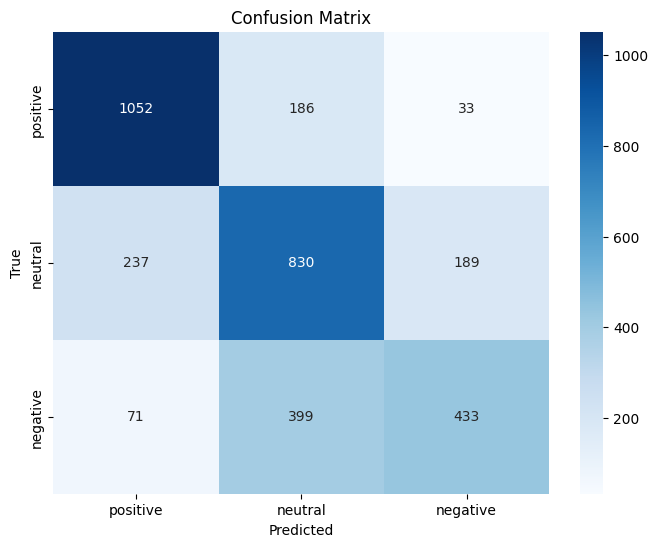

In [ ]:
# === SIMPAN CONFUSION MATRIX ===
labels = list(w2i.keys())
cm = confusion_matrix(list_label, list_hyp, labels=labels)
df_conf_matrix = pd.DataFrame(cm, index=[f"True_{l}" for l in labels], columns=[f"Pred_{l}" for l in labels])
df_conf_matrix.to_csv(os.path.join(output_dir,'confusion_matrix.csv'))

# === TAMPILKAN CONFUSION MATRIX ===
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.savefig(os.path.join(output_dir, 'confusion_matrix.png'))
plt.show()

In [ ]:
text = 'rafael mainnya jelek sekali'
subwords = tokenizer7.encode(text)
subwords = torch.LongTensor(subwords).view(1, -1).to(model7.device)

logits = model7(subwords)[0]
label = torch.topk(logits, k=1, dim=-1)[1].squeeze().item()

print(f'Text: {text} | Label : {i2w[label]} ({F.softmax(logits, dim=-1).squeeze()[label] * 100:.3f}%)')

Text: rafael mainnya jelek sekali | Label : negative (55.741%)


In [ ]:
text = 'sty stay'
subwords = tokenizer7.encode(text)
subwords = torch.LongTensor(subwords).view(1, -1).to(model7.device)

logits = model7(subwords)[0]
label = torch.topk(logits, k=1, dim=-1)[1].squeeze().item()

print(f'Text: {text} | Label : {i2w[label]} ({F.softmax(logits, dim=-1).squeeze()[label] * 100:.3f}%)')

Text: sty stay | Label : positive (97.648%)


### Learning Rate 5e-6

In [ ]:
tokenizer8 = DistilBertTokenizer.from_pretrained('distilbert/distilbert-base-multilingual-cased')
config8 = DistilBertConfig.from_pretrained('distilbert/distilbert-base-multilingual-cased')
config8.num_labels = DocumentSentimentDataset.NUM_LABELS
model8 = DistilBertForSequenceClassification.from_pretrained('distilbert/distilbert-base-multilingual-cased', config=config8)


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
model8

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)

In [ ]:
train_dataset8 = DocumentSentimentDataset(train_dataset_path, tokenizer8, lowercase=True)
valid_dataset8 = DocumentSentimentDataset(valid_dataset_path, tokenizer8, lowercase=True)
test_dataset8 = DocumentSentimentDataset(test_dataset_path, tokenizer8, lowercase=True)

train_loader8 = DocumentSentimentDataLoader(dataset=train_dataset8, max_seq_len=512, batch_size=32, num_workers=2, shuffle=True)
valid_loader8 = DocumentSentimentDataLoader(dataset=valid_dataset8, max_seq_len=512, batch_size=32, num_workers=2, shuffle=False)
test_loader8 = DocumentSentimentDataLoader(dataset=test_dataset8, max_seq_len=512, batch_size=32, num_workers=2, shuffle=False)

In [ ]:
w2i, i2w = DocumentSentimentDataset.LABEL2INDEX, DocumentSentimentDataset.INDEX2LABEL
print(w2i)
print(i2w)

{'positive': 0, 'neutral': 1, 'negative': 2}
{0: 'positive', 1: 'neutral', 2: 'negative'}


In [ ]:
text = 'bacot'
subwords = tokenizer8.encode(text)
subwords = torch.LongTensor(subwords).view(1, -1).to(model8.device)

logits = model8(subwords)[0]
label = torch.topk(logits, k=1, dim=-1)[1].squeeze().item()

print(f'Text: {text} | Label : {i2w[label]} ({F.softmax(logits, dim=-1).squeeze()[label] * 100:.3f}%)')

Text: bacot | Label : neutral (35.043%)


In [ ]:
text = 'taktik pelatih sty bagus'
subwords = tokenizer8.encode(text)
subwords = torch.LongTensor(subwords).view(1, -1).to(model8.device)

logits = model8(subwords)[0]
label = torch.topk(logits, k=1, dim=-1)[1].squeeze().item()

print(f'Text: {text} | Label : {i2w[label]} ({F.softmax(logits, dim=-1).squeeze()[label] * 100:.3f}%)')

Text: taktik pelatih sty bagus | Label : neutral (35.532%)


In [ ]:
optimizer = optim.Adam(model8.parameters(), lr=3e-6)
model = model8.cuda()

In [ ]:
# Metrik penyimpanan untuk model kedelapan
train_losses8, train_accuracies8 = [], []
valid_losses8, valid_accuracies8 = [], []

# Early stopping
patience = 3
best_valid_loss = float('inf')
best_model_state = None
counter = 0

torch.cuda.reset_peak_memory_stats()
start_time = time.time()

n_epochs = 15

for epoch in range(n_epochs):
    print(f"\nEpoch {epoch+1}/{n_epochs}")

    # === TRAINING ===
    model8.train()
    torch.set_grad_enabled(True)

    total_train_loss = 0
    list_hyp, list_label = [], []

    train_pbar = tqdm(train_loader8, desc=f"Training Epoch {epoch+1}", leave=True)
    for i, batch_data in enumerate(train_pbar):
        batch_inputs = {
            "input_ids": torch.tensor(batch_data[0]).to(model8.device),
            "attention_mask": torch.tensor(batch_data[1]).to(model8.device),
        }
        if len(batch_data) > 2:
            batch_inputs["labels"] = torch.tensor(batch_data[2]).to(model8.device)

        outputs = model8(**batch_inputs)
        loss = outputs.loss
        logits = outputs.logits

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()

        batch_hyp = torch.argmax(logits, dim=1).cpu().tolist()
        batch_label = batch_inputs["labels"].cpu().tolist()

        id2label = {0: 'positive', 1: 'neutral', 2: 'negative'}
        list_hyp_str = [id2label[i] for i in batch_hyp]
        list_label_str = [id2label[i[0]] for i in batch_label]

        list_hyp.extend(list_hyp_str)
        list_label.extend(list_label_str)

    train_metrics = document_sentiment_metrics_fn(list_hyp, list_label)
    avg_train_loss = total_train_loss / len(train_loader8)
    train_losses8.append(avg_train_loss)
    train_accuracies8.append(train_metrics['ACC'])

    # === VALIDATION ===
    model8.eval()
    torch.set_grad_enabled(False)

    total_valid_loss = 0
    list_hyp_valid, list_label_valid = [], []

    valid_pbar = tqdm(valid_loader8, desc=f"Validating Epoch {epoch+1}", leave=True)
    for batch_data in valid_pbar:
        batch_inputs = {
            "input_ids": torch.tensor(batch_data[0]).to(model8.device),
            "attention_mask": torch.tensor(batch_data[1]).to(model8.device),
        }
        if len(batch_data) > 2:
            batch_inputs["labels"] = torch.tensor(batch_data[2]).to(model8.device)

        outputs = model8(**batch_inputs)
        loss = outputs.loss
        logits = outputs.logits

        total_valid_loss += loss.item()

        batch_hyp = torch.argmax(logits, dim=1).cpu().tolist()
        batch_label = batch_inputs["labels"].cpu().tolist()

        list_hyp_valid += [id2label[i] for i in batch_hyp]
        list_label_valid += [id2label[i[0]] for i in batch_label]

    valid_metrics = document_sentiment_metrics_fn(list_hyp_valid, list_label_valid)
    avg_valid_loss = total_valid_loss / len(valid_loader8)
    valid_losses8.append(avg_valid_loss)
    valid_accuracies8.append(valid_metrics['ACC'])

    print(f"Epoch {epoch+1}/{n_epochs} | "
          f"Train Loss: {avg_train_loss:.4f} | Train Acc: {train_metrics['ACC']:.4f} | "
          f"Valid Loss: {avg_valid_loss:.4f} | Valid Acc: {valid_metrics['ACC']:.4f}")

    # === EARLY STOPPING ===
    if avg_valid_loss < best_valid_loss:
        best_valid_loss = avg_valid_loss
        best_model_state = copy.deepcopy(model8.state_dict())
        counter = 0
    else:
        counter += 1
        print(f"Valid loss tidak membaik selama {counter} epoch berturut-turut.")
        if counter >= patience:
            print(f"Early stopping aktif di epoch {epoch+1}. Training dihentikan.")
            break

# Load model terbaik
if best_model_state is not None:
    model8.load_state_dict(best_model_state)

end_time = time.time()
distilbert2_train_time = end_time - start_time
distilbert2_peak_memory = torch.cuda.max_memory_allocated() / 1024**2

print(f"\nDistilBERT2 - Waktu training: {distilbert2_train_time:.2f} detik | Peak memory: {distilbert2_peak_memory:.2f} MB")



Epoch 1/15


Validating Epoch 1: 100%|██████████| 86/86 [00:03<00:00, 22.84it/s]


Epoch 1/15 | Train Loss: 1.0028 | Train Acc: 0.4892 | Valid Loss: 0.8644 | Valid Acc: 0.5849

Epoch 2/15


Validating Epoch 2: 100%|██████████| 86/86 [00:03<00:00, 22.82it/s]


Epoch 2/15 | Train Loss: 0.8070 | Train Acc: 0.6233 | Valid Loss: 0.7918 | Valid Acc: 0.6261

Epoch 3/15


Validating Epoch 3: 100%|██████████| 86/86 [00:03<00:00, 22.31it/s]


Epoch 3/15 | Train Loss: 0.7346 | Train Acc: 0.6706 | Valid Loss: 0.7659 | Valid Acc: 0.6501

Epoch 4/15


Validating Epoch 4: 100%|██████████| 86/86 [00:03<00:00, 21.70it/s]


Epoch 4/15 | Train Loss: 0.6833 | Train Acc: 0.6991 | Valid Loss: 0.7553 | Valid Acc: 0.6614

Epoch 5/15


Validating Epoch 5: 100%|██████████| 86/86 [00:03<00:00, 22.57it/s]


Epoch 5/15 | Train Loss: 0.6449 | Train Acc: 0.7168 | Valid Loss: 0.7421 | Valid Acc: 0.6778

Epoch 6/15


Validating Epoch 6: 100%|██████████| 86/86 [00:03<00:00, 22.94it/s]


Epoch 6/15 | Train Loss: 0.6028 | Train Acc: 0.7417 | Valid Loss: 0.7435 | Valid Acc: 0.6808
Valid loss tidak membaik selama 1 epoch berturut-turut.

Epoch 7/15


Validating Epoch 7: 100%|██████████| 86/86 [00:03<00:00, 22.51it/s]


Epoch 7/15 | Train Loss: 0.5723 | Train Acc: 0.7644 | Valid Loss: 0.7449 | Valid Acc: 0.6888
Valid loss tidak membaik selama 2 epoch berturut-turut.

Epoch 8/15


Validating Epoch 8: 100%|██████████| 86/86 [00:04<00:00, 21.21it/s]

Epoch 8/15 | Train Loss: 0.5411 | Train Acc: 0.7774 | Valid Loss: 0.7468 | Valid Acc: 0.6924
Valid loss tidak membaik selama 3 epoch berturut-turut.
Early stopping aktif di epoch 8. Training dihentikan.

DistilBERT2 - Waktu training: 442.14 detik | Peak memory: 10125.58 MB


In [ ]:
!nvidia-smi

Sun May 18 15:00:50 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   69C    P0             30W /   70W |   10614MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

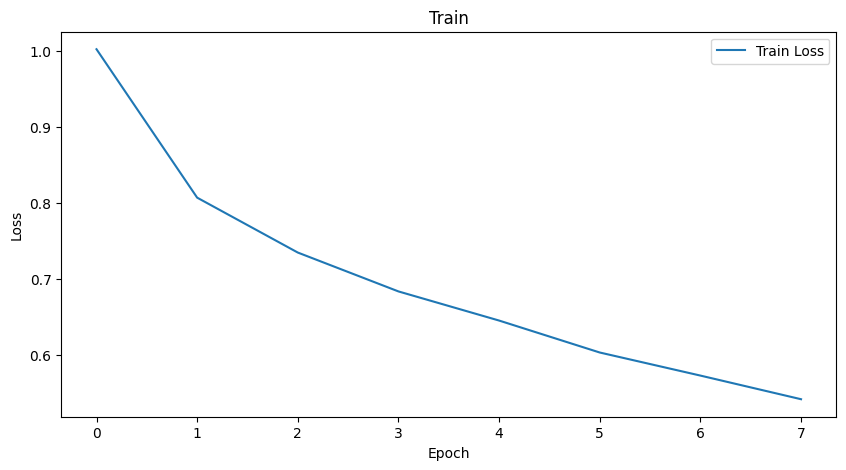

In [ ]:
# Plot loss
plt.figure(figsize=(10,5))
plt.plot(train_losses8, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Train')
plt.show()

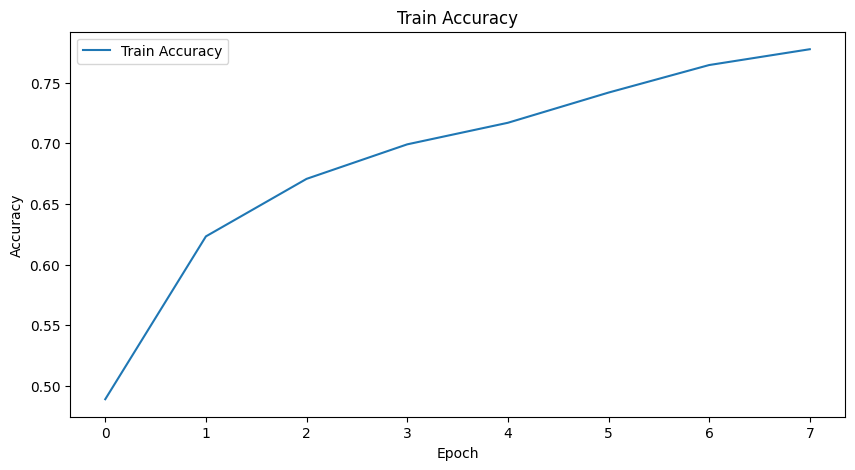

In [ ]:
# Plot akurasi
plt.figure(figsize=(10,5))
plt.plot(train_accuracies8, label='Train Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Train Accuracy')
plt.show()

In [ ]:
output_dir = '/content/drive/MyDrive/Skripsi/Piala_Asia/20rb/result/DistilBERT_Results/2'
os.makedirs(output_dir, exist_ok=True)

In [ ]:
list_hyp, list_label = [], []
all_texts = []

test_pbar = tqdm(test_loader8, leave=True, total=len(test_loader8))
for i, batch_data in enumerate(test_pbar):
    batch_inputs = {
        "input_ids": torch.tensor(batch_data[0]).to(model.device),
        "attention_mask": torch.tensor(batch_data[1]).to(model.device),
    }

    if len(batch_data) > 2:
        batch_inputs["labels"] = torch.tensor(batch_data[2]).to(model.device)
        batch_texts = batch_data[-1]  # Ambil teks dari batch (asumsinya di posisi terakhir)

    outputs = model(**batch_inputs)
    loss = outputs.loss
    logits = outputs.logits

    total_test_loss += loss.item()

    batch_hyp = torch.argmax(logits, dim=1).cpu().tolist()
    batch_label = batch_inputs["labels"].cpu().tolist()

    # Flatten batch_label if it's a list of lists
    batch_label = [item for sublist in batch_label for item in sublist]

    id2label = {0: 'positive', 1: 'neutral', 2: 'negative'}
    batch_label_str = [id2label[i] for i in batch_label]
    batch_hyp_str = [id2label[i] for i in batch_hyp]

    list_hyp.extend(batch_hyp_str)
    list_label.extend(batch_label_str)
    all_texts.extend(batch_texts)

# Simpan hasil ke CSV
df_result = pd.DataFrame({
    'text': all_texts,
    'true_label': list_label,
    'predicted_label': list_hyp
})
df_result.to_csv(os.path.join(output_dir,'hasil_prediksi_model8.csv'), index=False)

# Hitung metrik evaluasi
test_metrics = document_sentiment_metrics_fn(list_hyp, list_label)
print(f'\nTest Metrics: {metrics_to_string(test_metrics)}')

100%|██████████| 108/108 [00:04<00:00, 21.91it/s]


Test Metrics: ACC:0.69 F1:0.67 REC:0.67 PRE:0.68


In [ ]:
# === SIMPAN METRIK PER EPOCH ===
df_metrics_epoch = pd.DataFrame({
    'epoch': list(range(1, len(train_losses8)+1)),
    'train_loss': train_losses8,
    'train_accuracy': train_accuracies8,
    'valid_loss': valid_losses8,
    'valid_accuracy': valid_accuracies8
})
df_metrics_epoch.to_csv(os.path.join(output_dir,'metrics_per_epoch.csv'), index=False)

# === SIMPAN WAKTU DAN MEMORI ===
df_time_memory = pd.DataFrame({
    'model': ['DistilBERT'],
    'train_time_seconds': [distilbert2_train_time],
    'peak_memory_MB': [distilbert2_peak_memory]
})
df_time_memory.to_csv(os.path.join(output_dir,'time_memory.csv'), index=False)

# === SIMPAN METRIK TEST ===
test_metrics = document_sentiment_metrics_fn(list_hyp, list_label)
test_metrics_dict = {
    'model': 'DistilBERT',
    **test_metrics
}
df_test_metrics = pd.DataFrame([test_metrics_dict])
df_test_metrics.to_csv(os.path.join(output_dir,'test_metrics.csv'), index=False)

# === SIMPAN CLASSIFICATION REPORT ===
report_dict = classification_report(list_label, list_hyp, output_dict=True, zero_division=0)
df_report = pd.DataFrame(report_dict).transpose()
df_report.to_csv(os.path.join(output_dir,'classification_report.csv'))

In [ ]:
# classification report
print(classification_report(list_label, list_hyp))

              precision    recall  f1-score   support

    negative       0.63      0.53      0.58       903
     neutral       0.60      0.68      0.64      1256
    positive       0.82      0.80      0.81      1271

    accuracy                           0.69      3430
   macro avg       0.68      0.67      0.67      3430
weighted avg       0.69      0.69      0.69      3430



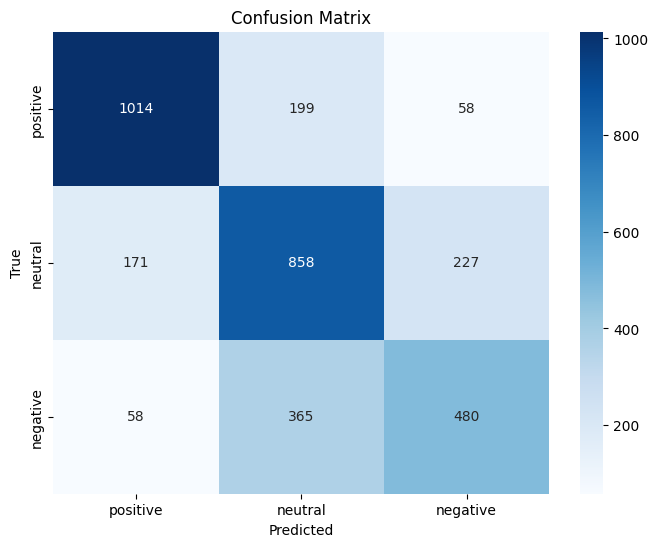

In [ ]:
# === SIMPAN CONFUSION MATRIX ===
labels = list(w2i.keys())
cm = confusion_matrix(list_label, list_hyp, labels=labels)
df_conf_matrix = pd.DataFrame(cm, index=[f"True_{l}" for l in labels], columns=[f"Pred_{l}" for l in labels])
df_conf_matrix.to_csv(os.path.join(output_dir,'confusion_matrix.csv'))

# === TAMPILKAN CONFUSION MATRIX ===
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.savefig(os.path.join(output_dir, 'confusion_matrix.png'))
plt.show()

In [ ]:
text = 'rafael mainnya jelek sekali'
subwords = tokenizer8.encode(text)
subwords = torch.LongTensor(subwords).view(1, -1).to(model8.device)

logits = model8(subwords)[0]
label = torch.topk(logits, k=1, dim=-1)[1].squeeze().item()

print(f'Text: {text} | Label : {i2w[label]} ({F.softmax(logits, dim=-1).squeeze()[label] * 100:.3f}%)')

Text: rafael mainnya jelek sekali | Label : negative (64.216%)


In [ ]:
text = 'sty stay'
subwords = tokenizer8.encode(text)
subwords = torch.LongTensor(subwords).view(1, -1).to(model8.device)

logits = model8(subwords)[0]
label = torch.topk(logits, k=1, dim=-1)[1].squeeze().item()

print(f'Text: {text} | Label : {i2w[label]} ({F.softmax(logits, dim=-1).squeeze()[label] * 100:.3f}%)')

Text: sty stay | Label : positive (97.770%)


### Learning Rate 5e-5

In [ ]:
tokenizer9 = DistilBertTokenizer.from_pretrained('distilbert/distilbert-base-multilingual-cased')
config9 = DistilBertConfig.from_pretrained('distilbert/distilbert-base-multilingual-cased')
config9.num_labels = DocumentSentimentDataset.NUM_LABELS
model9 = DistilBertForSequenceClassification.from_pretrained('distilbert/distilbert-base-multilingual-cased', config=config9)


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
train_dataset9 = DocumentSentimentDataset(train_dataset_path, tokenizer9, lowercase=True)
valid_dataset9 = DocumentSentimentDataset(valid_dataset_path, tokenizer9, lowercase=True)
test_dataset9 = DocumentSentimentDataset(test_dataset_path, tokenizer9, lowercase=True)

train_loader9 = DocumentSentimentDataLoader(dataset=train_dataset9, max_seq_len=512, batch_size=32, num_workers=2, shuffle=True)
valid_loader9 = DocumentSentimentDataLoader(dataset=valid_dataset9, max_seq_len=512, batch_size=32, num_workers=2, shuffle=False)
test_loader9 = DocumentSentimentDataLoader(dataset=test_dataset9, max_seq_len=512, batch_size=32, num_workers=2, shuffle=False)

In [ ]:
w2i, i2w = DocumentSentimentDataset.LABEL2INDEX, DocumentSentimentDataset.INDEX2LABEL
print(w2i)
print(i2w)

{'positive': 0, 'neutral': 1, 'negative': 2}
{0: 'positive', 1: 'neutral', 2: 'negative'}


In [ ]:
text = 'bacot'
subwords = tokenizer9.encode(text)
subwords = torch.LongTensor(subwords).view(1, -1).to(model9.device)

logits = model9(subwords)[0]
label = torch.topk(logits, k=1, dim=-1)[1].squeeze().item()

print(f'Text: {text} | Label : {i2w[label]} ({F.softmax(logits, dim=-1).squeeze()[label] * 100:.3f}%)')

Text: bacot | Label : neutral (34.360%)


In [ ]:
text = 'taktik pelatih sty bagus'
subwords = tokenizer9.encode(text)
subwords = torch.LongTensor(subwords).view(1, -1).to(model9.device)

logits = model9(subwords)[0]
label = torch.topk(logits, k=1, dim=-1)[1].squeeze().item()

print(f'Text: {text} | Label : {i2w[label]} ({F.softmax(logits, dim=-1).squeeze()[label] * 100:.3f}%)')

Text: taktik pelatih sty bagus | Label : negative (34.980%)


In [ ]:
optimizer = optim.Adam(model9.parameters(), lr=5e-5)
model = model9.cuda()

In [ ]:
# Metrik penyimpanan
train_losses9, train_accuracies9 = [], []
valid_losses9, valid_accuracies9 = [], []

# Early stopping
patience = 3
best_valid_loss = float('inf')
best_model_state = None
counter = 0

torch.cuda.reset_peak_memory_stats()
start_time = time.time()

n_epochs = 15

for epoch in range(n_epochs):
    print(f"\nEpoch {epoch+1}/{n_epochs}")

    # === TRAINING ===
    model9.train()
    torch.set_grad_enabled(True)

    total_train_loss = 0
    list_hyp = []  # Initialize list_hyp as an empty list
    list_label = [] # Initialize list_label as an empty list

    train_pbar = tqdm(train_loader9, desc=f"Training Epoch {epoch+1}", leave=True)
    for i, batch_data in enumerate(train_pbar):
        batch_inputs = {
            "input_ids": torch.tensor(batch_data[0]).to(model9.device),
            "attention_mask": torch.tensor(batch_data[1]).to(model9.device),
        }
        if len(batch_data) > 2:
            batch_inputs["labels"] = torch.tensor(batch_data[2]).to(model9.device)

        outputs = model9(**batch_inputs)
        loss = outputs.loss
        logits = outputs.logits

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()

        batch_hyp = torch.argmax(logits, dim=1).cpu().tolist()
        batch_label = batch_inputs["labels"].cpu().tolist()

        id2label = {0: 'positive', 1: 'neutral', 2: 'negative'}
        list_hyp_str = [id2label[i] for i in batch_hyp]
        list_label_str = [id2label[i[0]] for i in batch_label]

        list_hyp.extend(list_hyp_str)
        list_label.extend(list_label_str)

    train_metrics = document_sentiment_metrics_fn(list_hyp, list_label)
    avg_train_loss = total_train_loss / len(train_loader9)
    train_losses9.append(avg_train_loss)
    train_accuracies9.append(train_metrics['ACC'])

    # === VALIDATION ===
    model9.eval()
    torch.set_grad_enabled(False)

    total_valid_loss = 0
    list_hyp_valid, list_label_valid = [], []

    valid_pbar = tqdm(valid_loader9, desc=f"Validating Epoch {epoch+1}", leave=True)
    for batch_data in valid_pbar:
        batch_inputs = {
            "input_ids": torch.tensor(batch_data[0]).to(model9.device),
            "attention_mask": torch.tensor(batch_data[1]).to(model9.device),
        }
        if len(batch_data) > 2:
            batch_inputs["labels"] = torch.tensor(batch_data[2]).to(model9.device)

        outputs = model9(**batch_inputs)
        loss = outputs.loss
        logits = outputs.logits

        total_valid_loss += loss.item()

        batch_hyp = torch.argmax(logits, dim=1).cpu().tolist()
        batch_label = batch_inputs["labels"].cpu().tolist()

        list_hyp_valid += [id2label[i] for i in batch_hyp]
        list_label_valid += [id2label[i[0]] for i in batch_label]

    valid_metrics = document_sentiment_metrics_fn(list_hyp_valid, list_label_valid)
    avg_valid_loss = total_valid_loss / len(valid_loader9)
    valid_losses9.append(avg_valid_loss)
    valid_accuracies9.append(valid_metrics['ACC'])

    print(f"Epoch {epoch+1}/{n_epochs} | "
          f"Train Loss: {avg_train_loss:.4f} | Train Acc: {train_metrics['ACC']:.4f} | "
          f"Valid Loss: {avg_valid_loss:.4f} | Valid Acc: {valid_metrics['ACC']:.4f}")

    # === EARLY STOPPING ===
    if avg_valid_loss < best_valid_loss:
        best_valid_loss = avg_valid_loss
        best_model_state = copy.deepcopy(model9.state_dict())
        counter = 0
    else:
        counter += 1
        print(f"Valid loss tidak membaik selama {counter} epoch berturut-turut.")
        if counter >= patience:
            print(f"Early stopping aktif di epoch {epoch+1}. Training dihentikan.")
            break

# Load model terbaik
if best_model_state is not None:
    model9.load_state_dict(best_model_state)

end_time = time.time()
distilbert3_train_time = end_time - start_time
distilbert3_peak_memory = torch.cuda.max_memory_allocated() / 1024**2

print(f"\nDistilBERT3 - Waktu training: {distilbert3_train_time:.2f} detik | Peak memory: {distilbert3_peak_memory:.2f} MB")


Epoch 1/15


Validating Epoch 1: 100%|██████████| 86/86 [00:04<00:00, 21.38it/s]


Epoch 1/15 | Train Loss: 0.8094 | Train Acc: 0.6155 | Valid Loss: 0.7130 | Valid Acc: 0.6804

Epoch 2/15


Validating Epoch 2: 100%|██████████| 86/86 [00:03<00:00, 22.65it/s]


Epoch 2/15 | Train Loss: 0.6029 | Train Acc: 0.7403 | Valid Loss: 0.6873 | Valid Acc: 0.6993

Epoch 3/15


Validating Epoch 3: 100%|██████████| 86/86 [00:03<00:00, 22.79it/s]


Epoch 3/15 | Train Loss: 0.4334 | Train Acc: 0.8244 | Valid Loss: 0.7961 | Valid Acc: 0.7128
Valid loss tidak membaik selama 1 epoch berturut-turut.

Epoch 4/15


Validating Epoch 4: 100%|██████████| 86/86 [00:03<00:00, 22.04it/s]


Epoch 4/15 | Train Loss: 0.2948 | Train Acc: 0.8899 | Valid Loss: 0.8301 | Valid Acc: 0.7037
Valid loss tidak membaik selama 2 epoch berturut-turut.

Epoch 5/15


Validating Epoch 5: 100%|██████████| 86/86 [00:03<00:00, 21.96it/s]

Epoch 5/15 | Train Loss: 0.2015 | Train Acc: 0.9283 | Valid Loss: 0.9354 | Valid Acc: 0.7034
Valid loss tidak membaik selama 3 epoch berturut-turut.
Early stopping aktif di epoch 5. Training dihentikan.

DistilBERT3 - Waktu training: 277.85 detik | Peak memory: 11165.72 MB


In [ ]:
!nvidia-smi

Sun May 18 15:08:12 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   73C    P0             32W /   70W |   11774MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

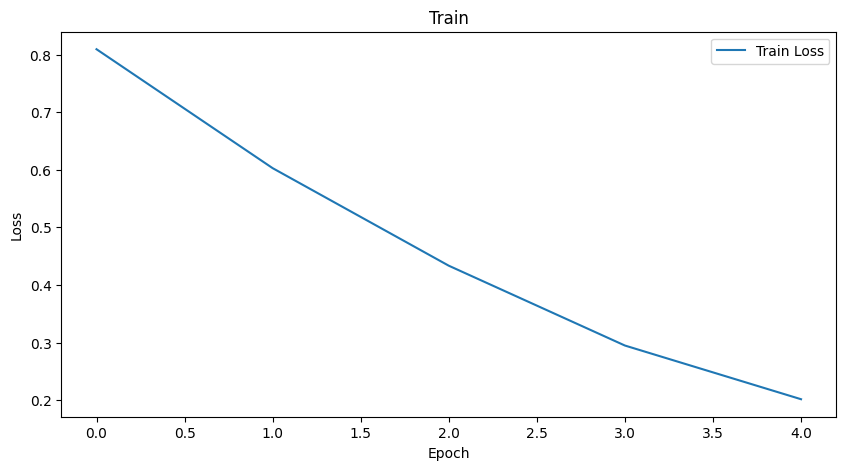

In [ ]:
# Plot loss
plt.figure(figsize=(10,5))
plt.plot(train_losses9, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Train')
plt.show()

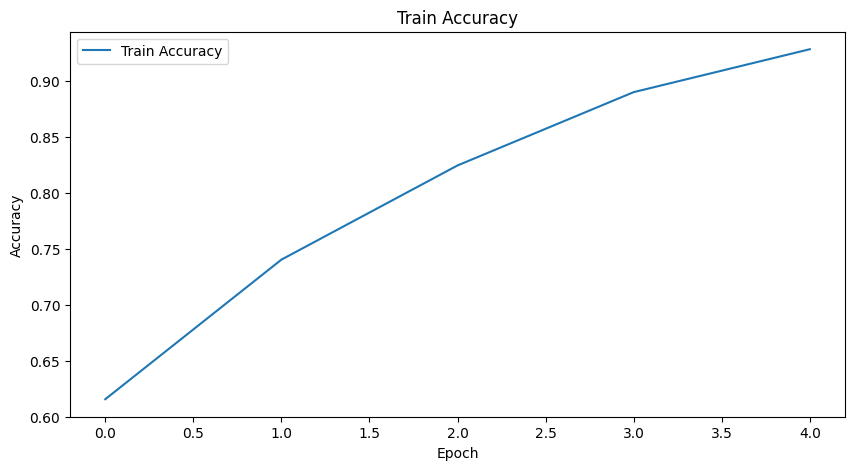

In [ ]:
# Plot akurasi
plt.figure(figsize=(10,5))
plt.plot(train_accuracies9, label='Train Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Train Accuracy')
plt.show()

In [ ]:
output_dir = '/content/drive/MyDrive/Skripsi/Piala_Asia/20rb/result/DistilBERT_Results/3'
os.makedirs(output_dir, exist_ok=True)

In [ ]:
list_hyp, list_label = [], []
all_texts = []

test_pbar = tqdm(test_loader9, leave=True, total=len(test_loader9))
for i, batch_data in enumerate(test_pbar):
    batch_inputs = {
        "input_ids": torch.tensor(batch_data[0]).to(model.device),
        "attention_mask": torch.tensor(batch_data[1]).to(model.device),
    }

    if len(batch_data) > 2:
        batch_inputs["labels"] = torch.tensor(batch_data[2]).to(model.device)
        batch_texts = batch_data[-1]  # Ambil teks dari batch (asumsinya di posisi terakhir)

    outputs = model(**batch_inputs)
    loss = outputs.loss
    logits = outputs.logits

    total_test_loss += loss.item()

    batch_hyp = torch.argmax(logits, dim=1).cpu().tolist()
    batch_label = batch_inputs["labels"].cpu().tolist()

    # Flatten batch_label if it's a list of lists
    batch_label = [item for sublist in batch_label for item in sublist]

    id2label = {0: 'positive', 1: 'neutral', 2: 'negative'}
    batch_label_str = [id2label[i] for i in batch_label]
    batch_hyp_str = [id2label[i] for i in batch_hyp]

    list_hyp.extend(batch_hyp_str)
    list_label.extend(batch_label_str)
    all_texts.extend(batch_texts)

# Simpan hasil ke CSV
df_result = pd.DataFrame({
    'text': all_texts,
    'true_label': list_label,
    'predicted_label': list_hyp
})
df_result.to_csv(os.path.join(output_dir,'hasil_prediksi_model9.csv'), index=False)

# Hitung metrik evaluasi
test_metrics = document_sentiment_metrics_fn(list_hyp, list_label)
print(f'\nTest Metrics: {metrics_to_string(test_metrics)}')

100%|██████████| 108/108 [00:04<00:00, 22.42it/s]


Test Metrics: ACC:0.71 F1:0.70 REC:0.70 PRE:0.70


In [ ]:
# === SIMPAN METRIK PER EPOCH ===
df_metrics_epoch = pd.DataFrame({
    'epoch': list(range(1, len(train_losses9)+1)),
    'train_loss': train_losses9,
    'train_accuracy': train_accuracies9,
    'valid_loss': valid_losses9,
    'valid_accuracy': valid_accuracies9
})
df_metrics_epoch.to_csv(os.path.join(output_dir,'metrics_per_epoch.csv'), index=False)

# === SIMPAN WAKTU DAN MEMORI ===
df_time_memory = pd.DataFrame({
    'model': ['DistilBERT'],
    'train_time_seconds': [distilbert3_train_time],
    'peak_memory_MB': [distilbert3_peak_memory]
})
df_time_memory.to_csv(os.path.join(output_dir,'time_memory.csv'), index=False)

# === SIMPAN METRIK TEST ===
test_metrics = document_sentiment_metrics_fn(list_hyp, list_label)
test_metrics_dict = {
    'model': 'DistilBERT',
    **test_metrics
}
df_test_metrics = pd.DataFrame([test_metrics_dict])
df_test_metrics.to_csv(os.path.join(output_dir,'test_metrics.csv'), index=False)

# === SIMPAN CLASSIFICATION REPORT ===
report_dict = classification_report(list_label, list_hyp, output_dict=True, zero_division=0)
df_report = pd.DataFrame(report_dict).transpose()
df_report.to_csv(os.path.join(output_dir,'classification_report.csv'))

In [ ]:
# classification report
print(classification_report(list_label, list_hyp))

              precision    recall  f1-score   support

    negative       0.63      0.64      0.64       903
     neutral       0.67      0.63      0.65      1256
    positive       0.81      0.84      0.82      1271

    accuracy                           0.71      3430
   macro avg       0.70      0.70      0.70      3430
weighted avg       0.71      0.71      0.71      3430



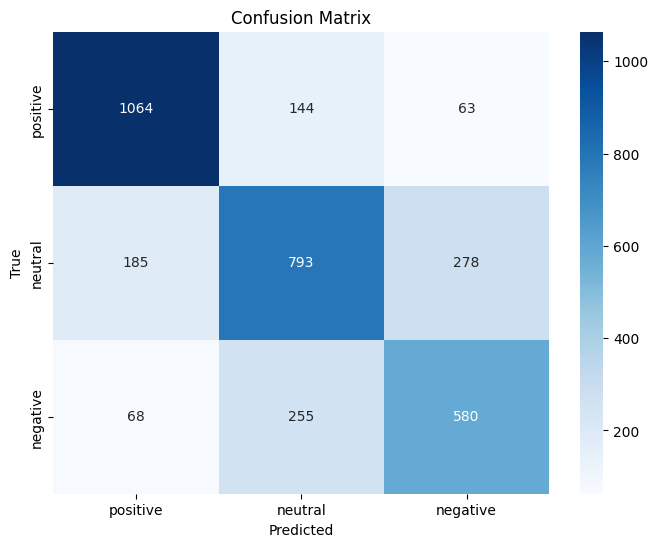

In [ ]:
# === SIMPAN CONFUSION MATRIX ===
labels = list(w2i.keys())
cm = confusion_matrix(list_label, list_hyp, labels=labels)
df_conf_matrix = pd.DataFrame(cm, index=[f"True_{l}" for l in labels], columns=[f"Pred_{l}" for l in labels])
df_conf_matrix.to_csv(os.path.join(output_dir,'confusion_matrix.csv'))

# === TAMPILKAN CONFUSION MATRIX ===
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.savefig(os.path.join(output_dir, 'confusion_matrix.png'))
plt.show()

In [ ]:
text = 'rafael mainnya jelek sekali'
subwords = tokenizer9.encode(text)
subwords = torch.LongTensor(subwords).view(1, -1).to(model9.device)

logits = model9(subwords)[0]
label = torch.topk(logits, k=1, dim=-1)[1].squeeze().item()

print(f'Text: {text} | Label : {i2w[label]} ({F.softmax(logits, dim=-1).squeeze()[label] * 100:.3f}%)')

Text: rafael mainnya jelek sekali | Label : negative (63.359%)


In [ ]:
text = 'sty stay'
subwords = tokenizer9.encode(text)
subwords = torch.LongTensor(subwords).view(1, -1).to(model9.device)

logits = model9(subwords)[0]
label = torch.topk(logits, k=1, dim=-1)[1].squeeze().item()

print(f'Text: {text} | Label : {i2w[label]} ({F.softmax(logits, dim=-1).squeeze()[label] * 100:.3f}%)')

Text: sty stay | Label : positive (98.499%)


## Visualisasi

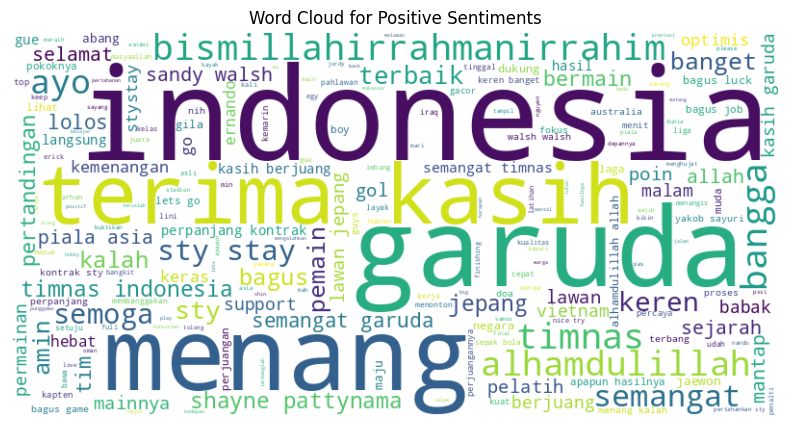

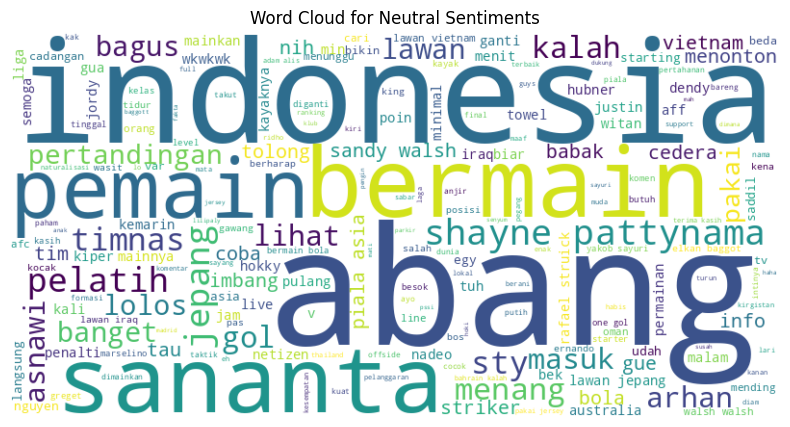

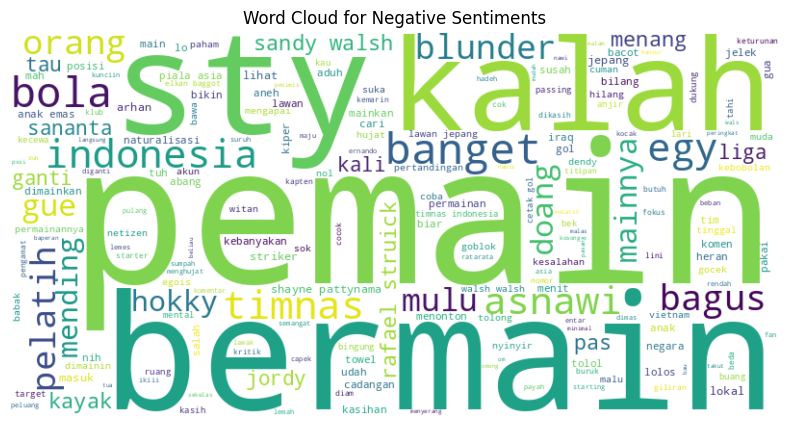

In [ ]:
!pip install wordcloud

from wordcloud import WordCloud
import matplotlib.pyplot as plt
import pandas as pd

# Load hasil prediksi
df_result = pd.read_csv('hasil_prediksi_model1.csv')  # Ganti dengan nama file yang sesuai

# Pisahkan teks berdasarkan sentimen
positive_texts = ' '.join(df_result[df_result['predicted_label'] == 'positive']['text'].tolist())
neutral_texts = ' '.join(df_result[df_result['predicted_label'] == 'neutral']['text'].tolist())
negative_texts = ' '.join(df_result[df_result['predicted_label'] == 'negative']['text'].tolist())

# Buat word cloud untuk setiap sentimen
sentiments = ['positive', 'neutral', 'negative']
texts = [positive_texts, neutral_texts, negative_texts]

for sentiment, text in zip(sentiments, texts):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f'Word Cloud for {sentiment.capitalize()} Sentiments')
    plt.show()


## Kesimpulan

Hasil penelitian menunjukkan bahwa model IndoBERT memberikan performa terbaik dengan akurasi sebesar 73,62% dan F1-score sebesar 72,42%. Model ini juga menunjukkan kemampuan klasifikasi yang seimbang antar kelas sentimen, sehingga cocok digunakan untuk tugas analisis sentimen dalam bahasa Indonesia. Di sisi lain, model IndoRoBERTa memiliki performa yang stabil serta efisiensi dalam waktu pelatihan, sementara DistilBERT menonjol dalam hal efisiensi komputasi, menjadikannya pilihan ideal untuk sistem dengan keterbatasan sumber daya.

Faktor-faktor yang turut memengaruhi kinerja model meliputi kualitas anotasi manual serta keseimbangan distribusi data sentimen dalam dataset. Temuan ini menunjukkan bahwa pemilihan model harus mempertimbangkan kebutuhan spesifik sistem, baik dari segi akurasi maupun efisiensi.

Model terbaik dari hasil eksperimen ini akan digunakan dalam pengembangan aplikasi web [Sentimen Timnas App](https://timnas-sentiment-analysis.streamlit.app/).
